# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from math import log2
import sklearn
import random

# additional imports if necessary

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy/Log Loss
3. Misclassification Error

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [416]:
# your code here
setoflabels = [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0]

##### Gini Index

In [417]:
def gini(list):
    giniindex=1
    listsize=len(list)
    frequencies=Counter(list)
    for i in frequencies:
        occurence=frequencies[i]
        occurence/=listsize
        occurence*=occurence
        giniindex-=occurence
        
    return giniindex
        
gini(setoflabels)

0.4444444444444445

##### Entropy/Log loss

In [418]:
def entropy(list):
    entropyval=0
    listsize=len(list)
    frequencies=Counter(list)
    for i in frequencies:
        occurence=frequencies[i]
        occurence/=listsize
        entropyval+=(occurence*log2(occurence))
        
    entropyval*=-1
    
    if entropyval==0:
        return 0
    
    return entropyval
    
entropy(setoflabels)

0.9182958340544896

##### Misclassification error

In [419]:
def misclasserror(list):
    misclassval=0
    listsize=len(list)
    frequencies=Counter(list)
    for i in frequencies:
        occurence=frequencies[i]
        occurence/=listsize
        misclassval=1-occurence
        break
        
    return misclassval
    
misclasserror(setoflabels)    

0.33333333333333337

### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [420]:
data = pd.read_csv('bankAuth.txt',header=None,names=['var','skew','curt','ent','label'])
data.head(5)

var    skew    curt      ent  label
0  3.62160  8.6661 -2.8073 -0.44699      0
1  4.54590  8.1674 -2.4586 -1.46210      0
2  3.86600 -2.6383  1.9242  0.10645      0
3  3.45660  9.5228 -4.0112 -3.59440      0
4  0.32924 -4.4552  4.5718 -0.98880      0

In [421]:
class Node():
    def __init__(self, feature=None, threshold=None, left=None, right=None, info_gain=None, value=None,impurity=None):
        
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.impurity = impurity
        self.value = value


In [422]:
# your code here

class DT():
    def __init__(self, minsplitcount=2, max_depth=3):
        
        self.root = None
        self.minsplitcount = minsplitcount
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        if num_samples>=self.minsplitcount and curr_depth<=self.max_depth:
            best_split = self.getbestsplit(dataset, num_samples, num_features)
            if best_split["info_gain"]>0:
                left = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature"], best_split["threshold"], left, right, best_split["info_gain"])
        
        leaf_value = self.leaf_val(Y)
        impval=entropy(Y)
        return Node(value=leaf_value,impurity=impval)
    
    def split(self, dataset, feature, threshold):
        dataset_left = np.array([row for row in dataset if row[feature]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature]>threshold])
        return dataset_left, dataset_right
    
    def getbestsplit(self, dataset, num_samples, num_features):
        
        best_split = {}
        max_info_gain = -float("inf")
        
        for feature in range(num_features):
            feature_values = dataset[:, feature]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.info_gain(y, left_y, right_y, "gini")
                    if curr_info_gain>max_info_gain:
                        best_split["feature"] = feature
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        return best_split
    
    def info_gain(self, parent, l_child, r_child, mode="entropy"):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = gini(parent) - (weight_l * gini(l_child) + weight_r * gini(r_child))
        elif mode=="misclass":
            gain = misclasserror(parent) - weight_l*misclasserror(l_child) + weight_l*misclasserror(r_child)
        else:
            gain = entropy(parent) - (weight_l*entropy(l_child) + weight_r*entropy(r_child))
        return gain
    
    def predict(self, X):
        
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
        
    def leaf_val(self, Y): 
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def make_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def generate_output(self, tree=None, indent=" "):  
        
        if not tree:
            tree = self.root
            
        if tree.feature==0:
            featurename="var"
        elif tree.feature==1:
            featurename="skew"
        elif tree.feature==2:
            featurename="curt"
        else:
            featurename="ent"
            
        if tree.value==0:
            verdict="forged"
        else:
            verdict="authentic"

        if tree.value is not None:
            print("Label:",verdict," and Impurity:",tree.impurity)

        else:
            print(featurename, "<= threshhold:", tree.threshold)
            print("%sleft:" % (indent), end="")
            self.generate_output(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.generate_output(tree.right, indent + indent)

In [423]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [424]:
classifier = DT(minsplitcount=2, max_depth=3)
classifier.fit(X_train,Y_train)

Y_pred = classifier.predict(X_test) 
from sklearn.metrics import accuracy_score
print("Accuracy score is :",accuracy_score(Y_test, Y_pred))



Accuracy score is : 0.9454545454545454


In [425]:
classifier.generate_output()

var <= threshhold: 0.30081
 left:skew <= threshhold: 5.1401
  left:curt <= threshhold: 6.7019
    left:skew <= threshhold: 4.0723
        left:Label: authentic  and Impurity: 0.032694298886860707
        right:Label: authentic  and Impurity: 0.4394969869215134
    right:skew <= threshhold: -4.9932
        left:Label: authentic  and Impurity: 0.08426242877623302
        right:Label: forged  and Impurity: 0
  right:var <= threshhold: -4.1479
    left:curt <= threshhold: 1.0836
        left:Label: authentic  and Impurity: 0
        right:Label: forged  and Impurity: 0
    right:Label: forged  and Impurity: 0
 right:curt <= threshhold: -4.3882
  left:var <= threshhold: 2.2279
    left:Label: authentic  and Impurity: 0
    right:Label: forged  and Impurity: 0
  right:var <= threshhold: 1.0552
    left:curt <= threshhold: -1.7859
        left:Label: authentic  and Impurity: 0.5032583347756457
        right:Label: forged  and Impurity: 0.5665095065529053
    right:var <= threshhold: 2.031
   

### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

Answer:

- When the values of Y (or the observation results) are discrete classes such as Yes/No or are from a limited set of classes, Decision tree classifier is preferred. However, if the same observation results Y have a range of values or appear continuous, then a Decision tree regressor is preferred.

- In the case of the bank authentication dataset, since the observation results are either 1 (Authentic) or 0 (Forged) banknotes, a decision tree classifier is preferred.

- In order to use decision tree regressor on the dataset, the observed results should be continuous values. A possibility may be a probability of the note being real or not with values like 0.9 or 0.5 indicating that the banknote is 90% or 50% likely to be real

---

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

- Answers 2,3 at the bottom

---

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

In [426]:
# your code here
from sklearn.tree import plot_tree
def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [427]:
data = pd.read_csv('bankAuth.txt',header=None,names=['var','skew','curt','ent','label'])
print(data.describe())

print()
print()
print()

print(data.info())

               var         skew         curt          ent        label
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   var     1372 non-null   float64
 1   skew    1372 non-null   float64
 2   curt    1372 non-null   float64
 3   ent     1372 non-null   float64
 4   label   1372 non-null   i

In [428]:
# your code here

### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [429]:
# your code here
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

#### Varying tree levels

Accuracy value: 0.8836363636363637


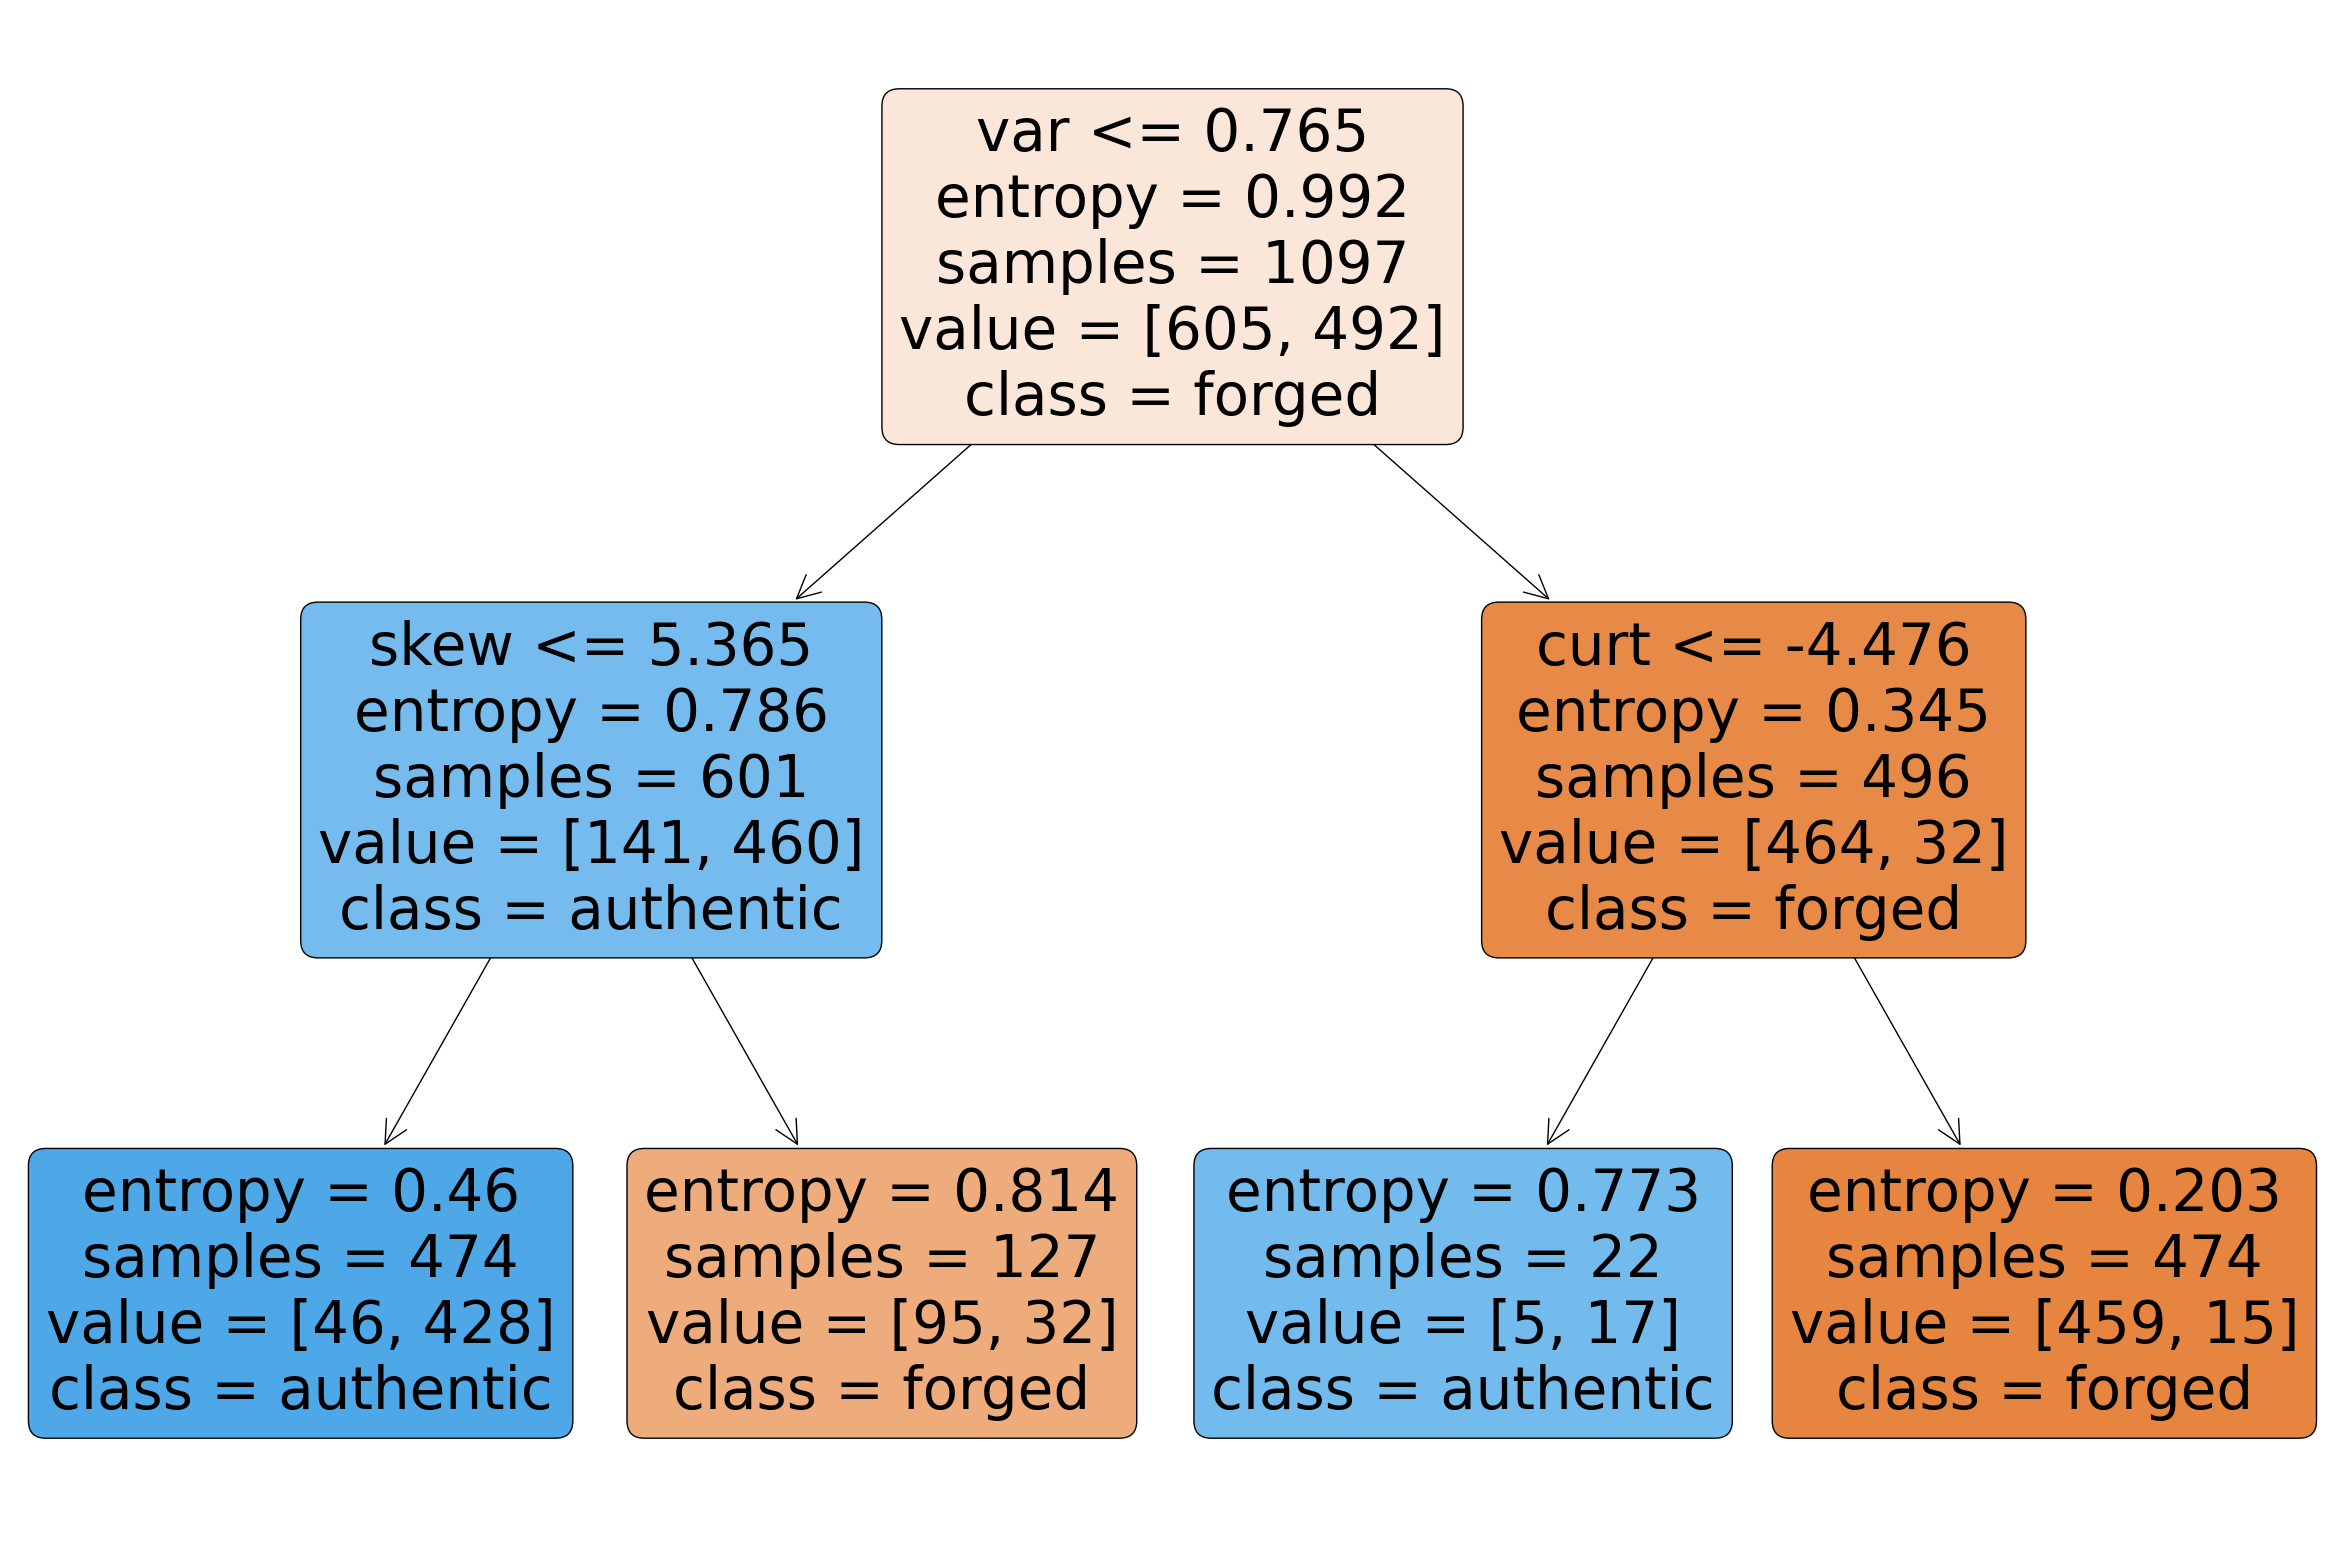

Accuracy value: 0.9236363636363636


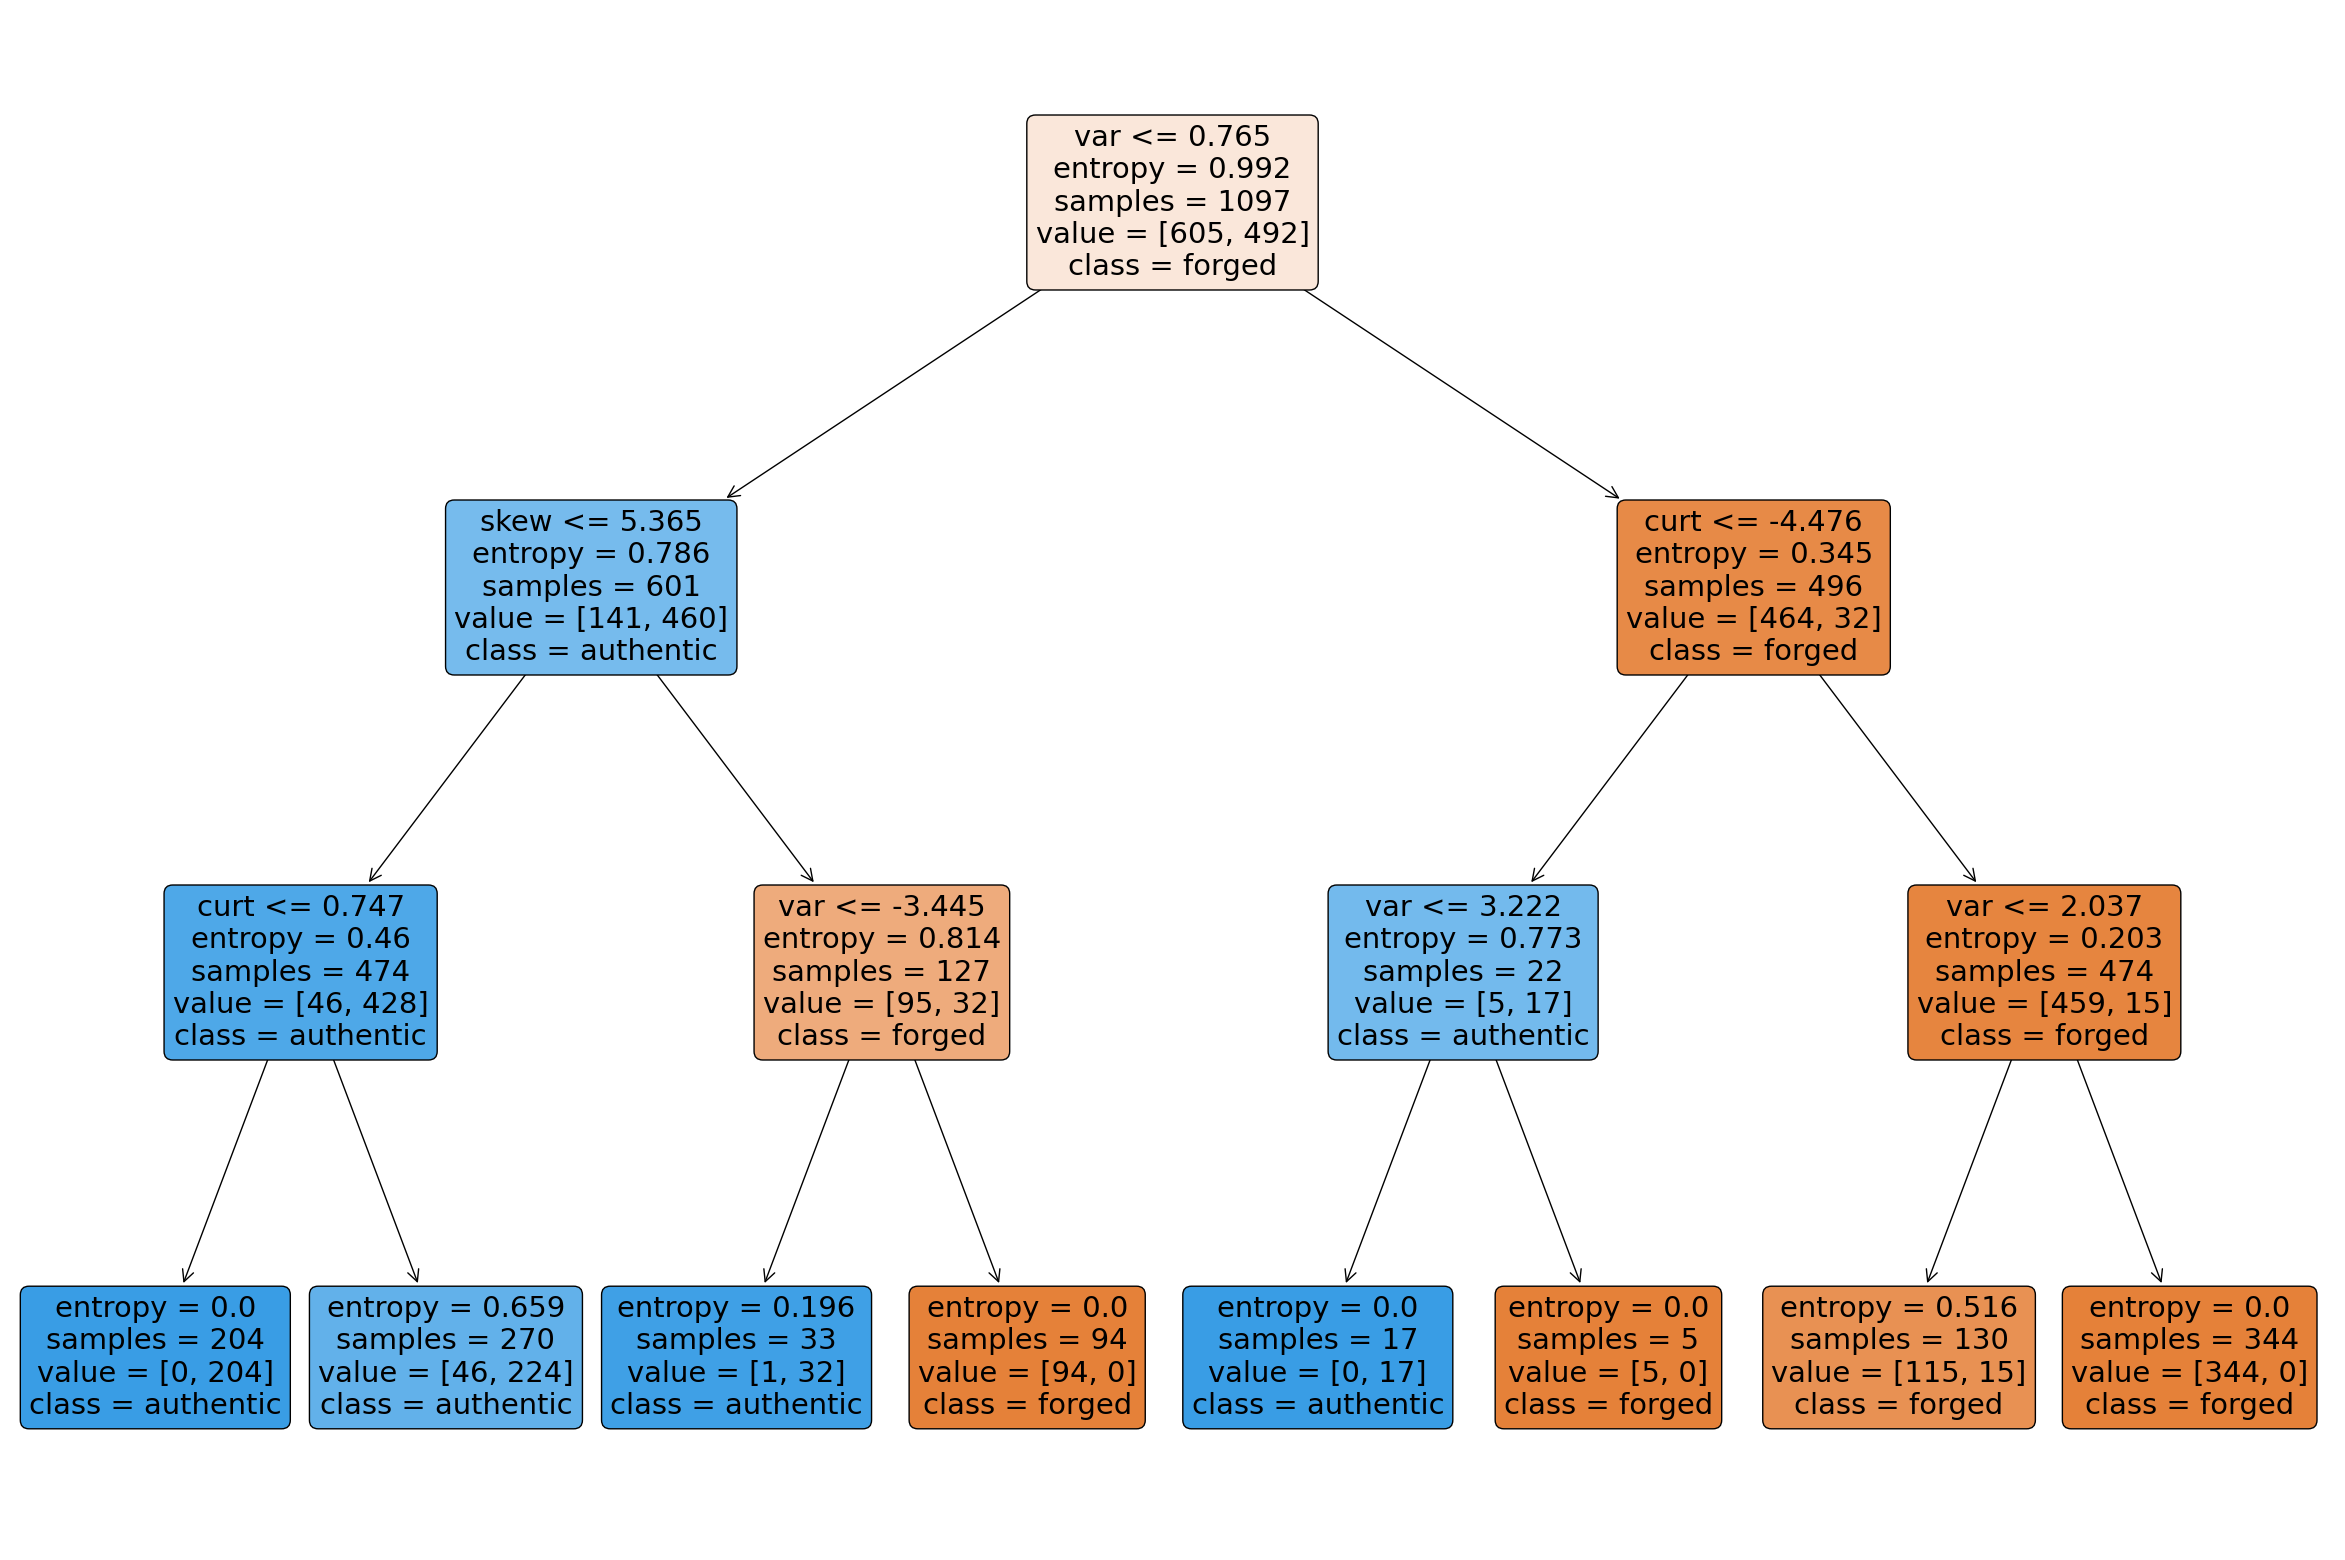

Accuracy value: 0.96


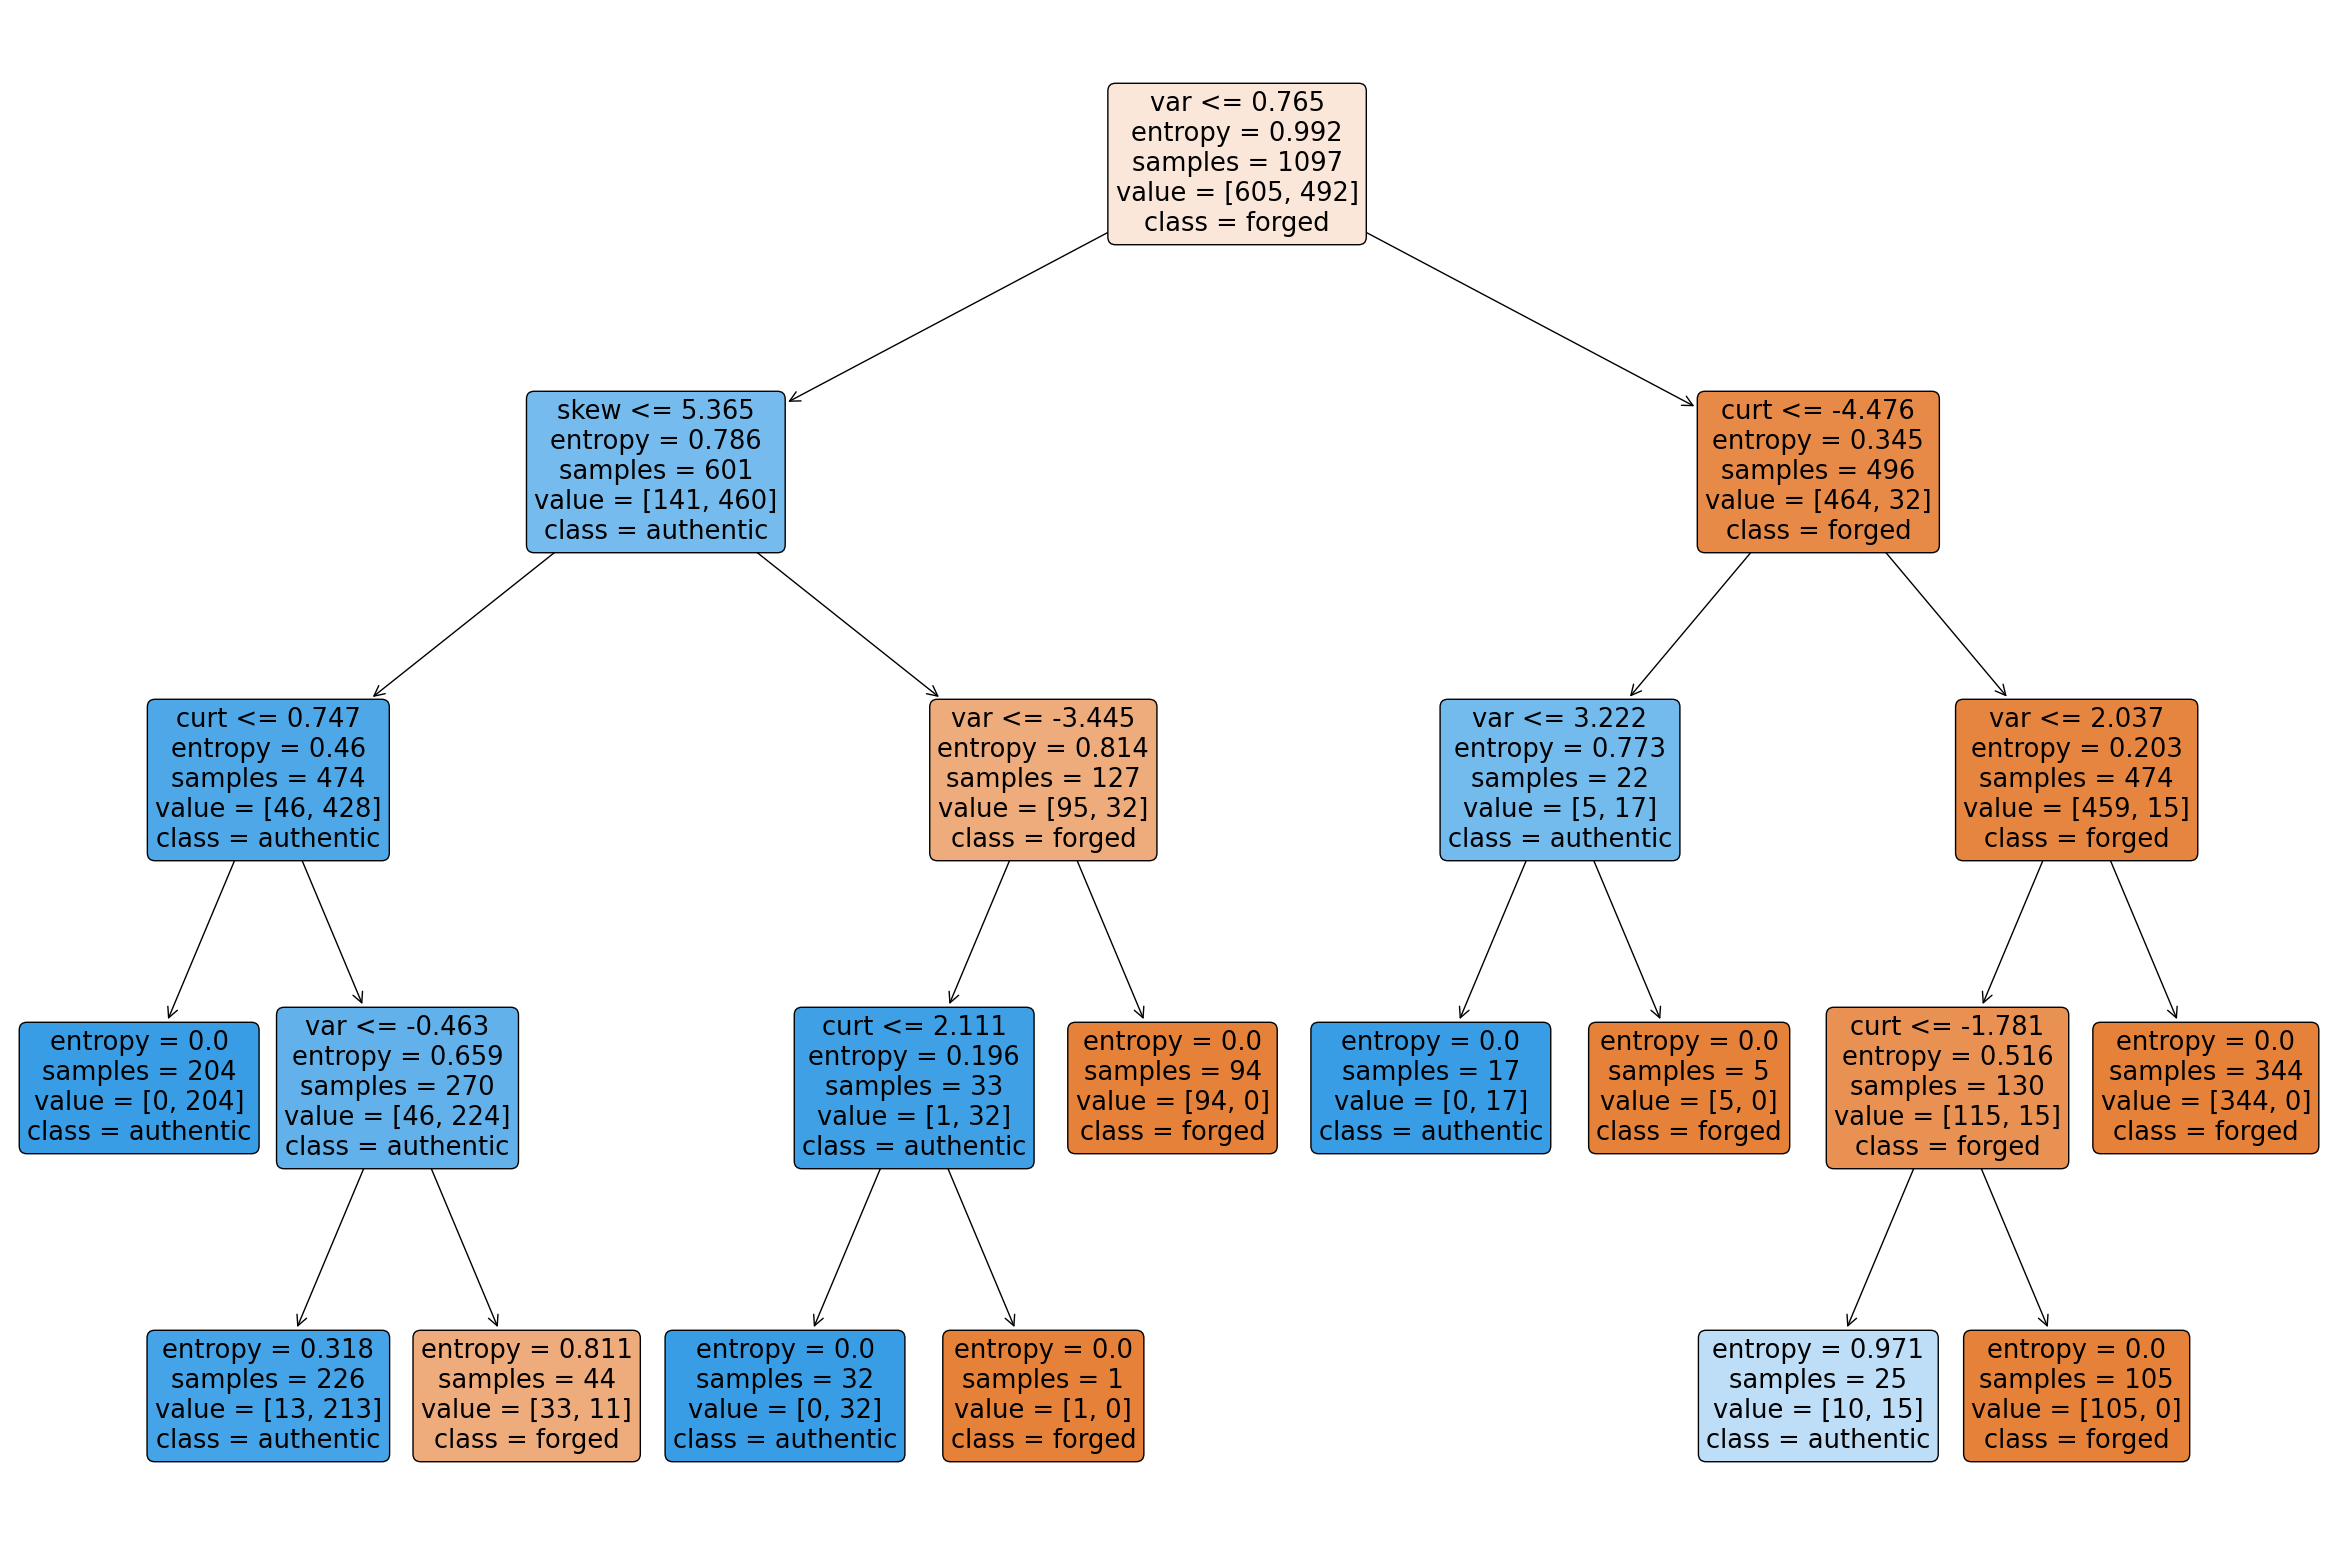

Accuracy value: 0.9818181818181818


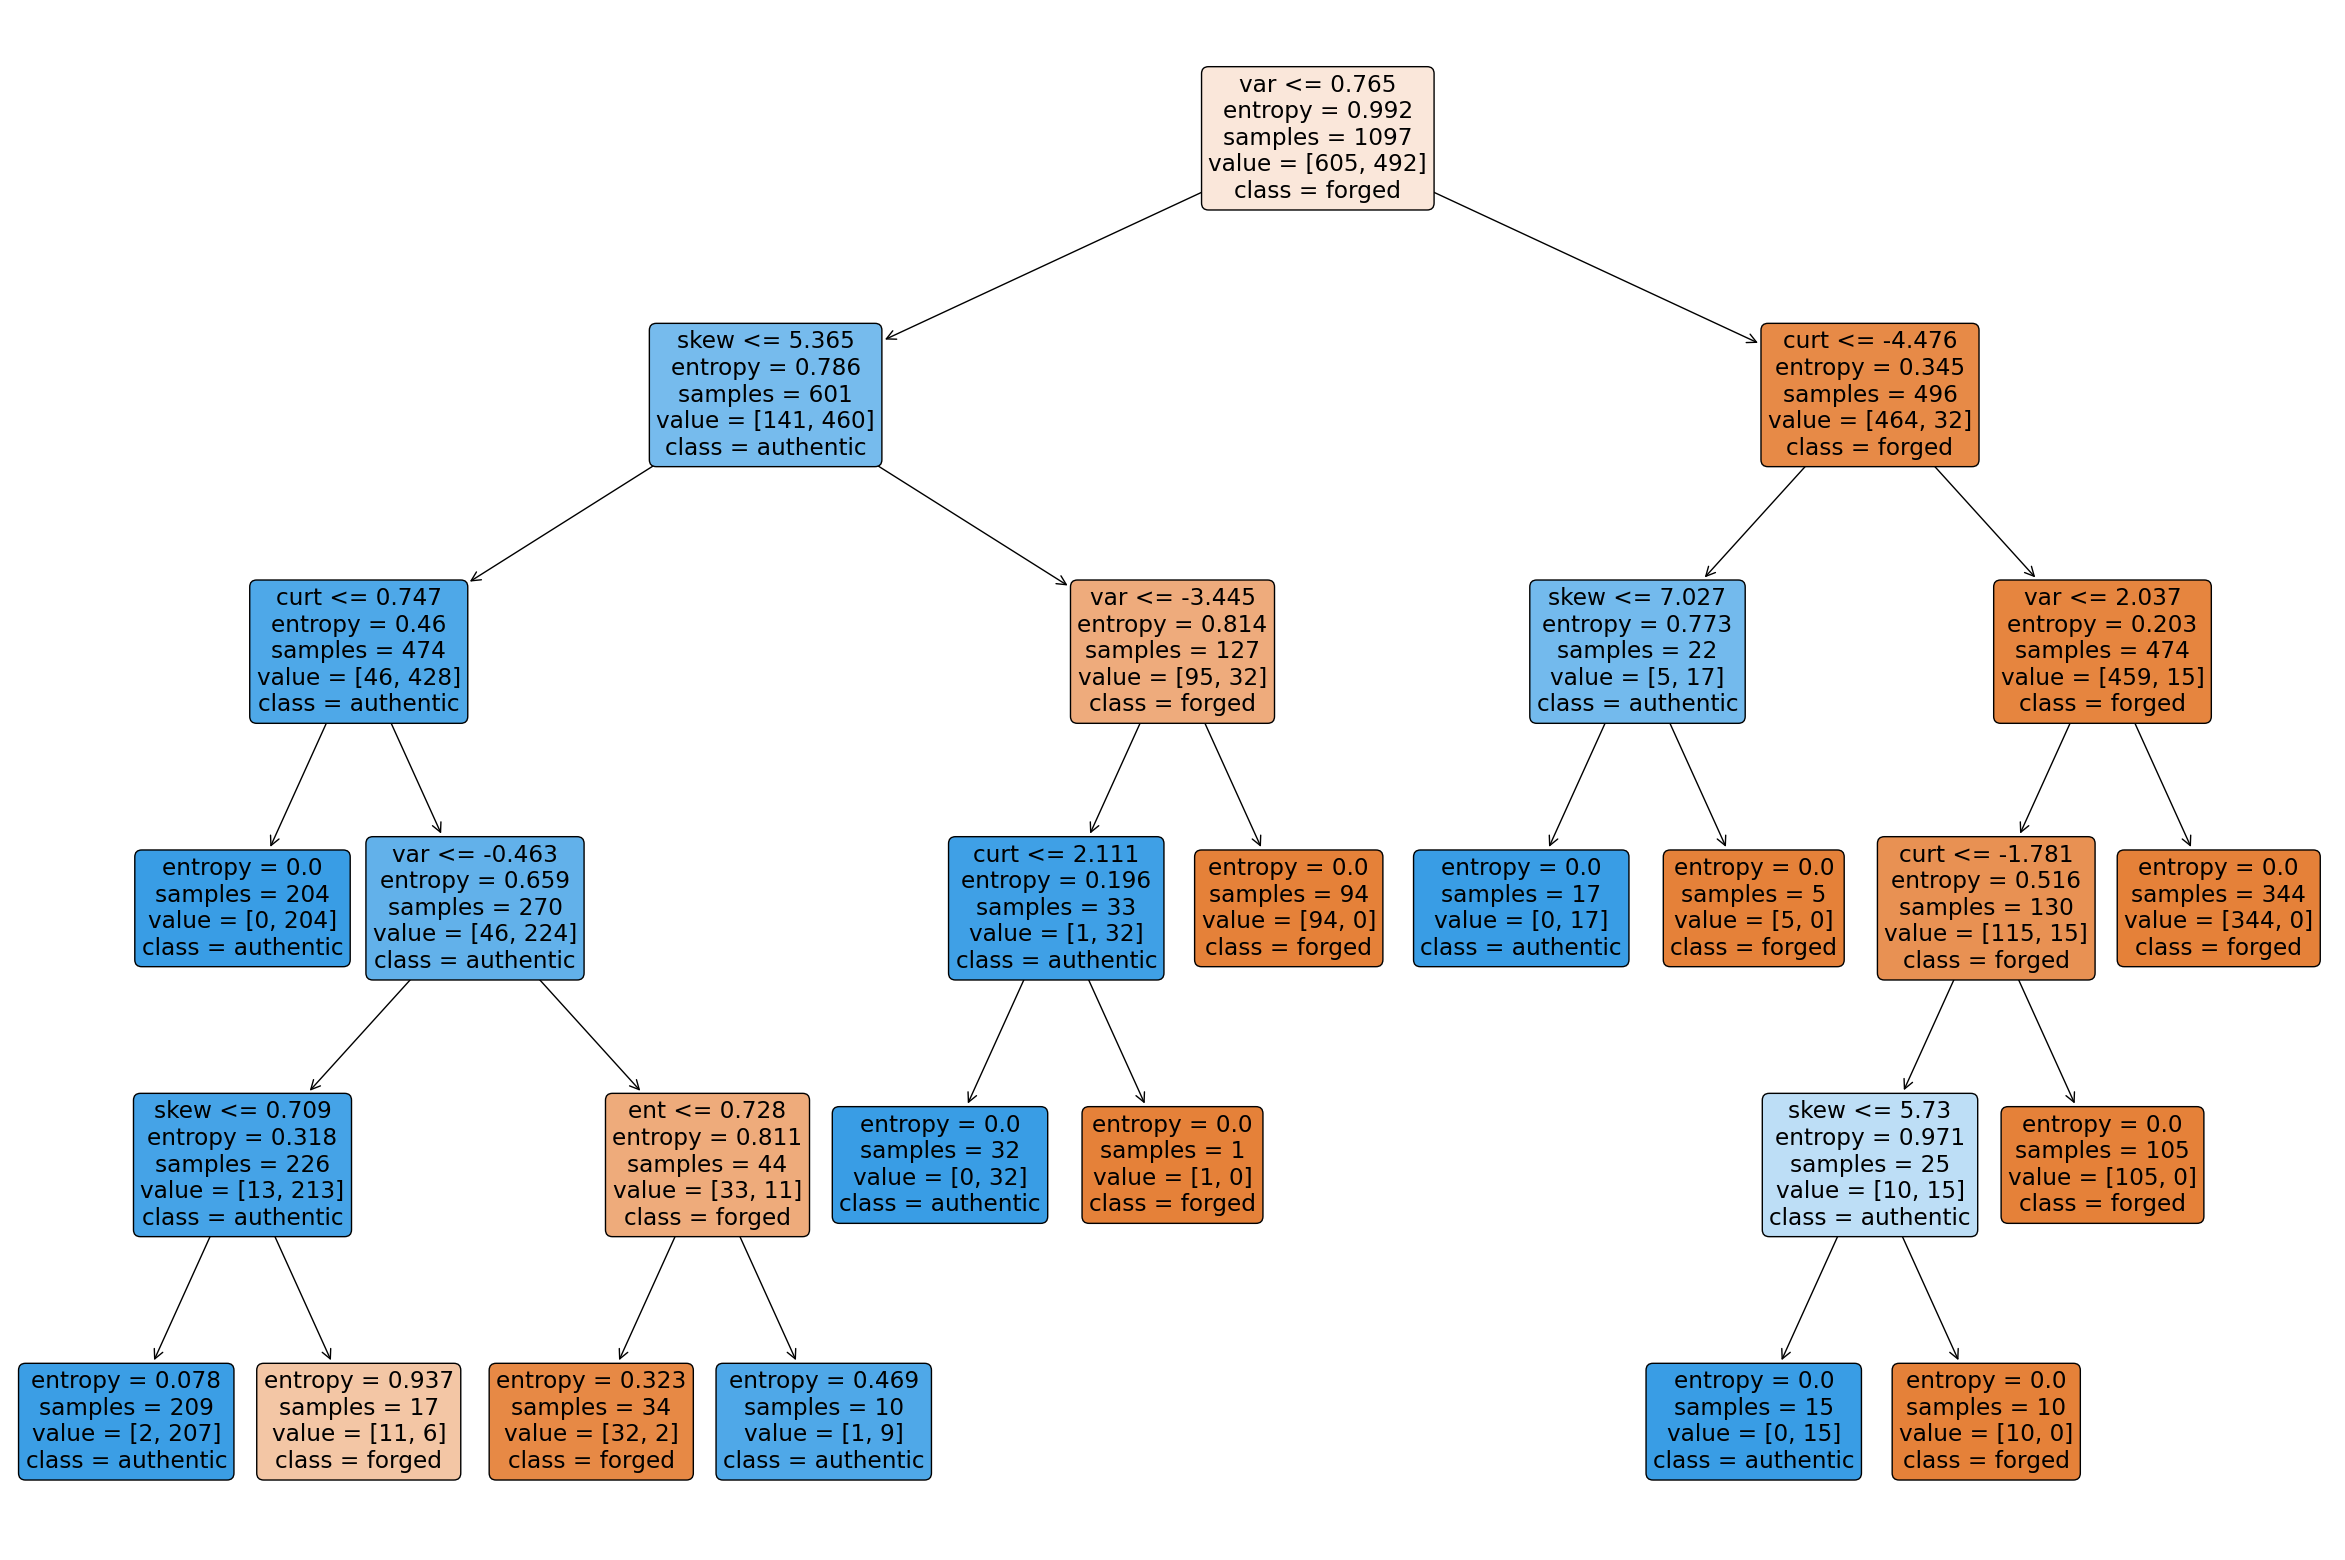

In [430]:
from sklearn.tree import DecisionTreeClassifier
for i in [2,3,4,5]:
    clf = DecisionTreeClassifier(criterion='entropy',max_depth=i,min_samples_split=2)
    clf.fit(X_train,Y_train)
    Y_pred = clf.predict(X_test)
    print("Accuracy value:",accuracy_score(Y_test, Y_pred))
    plotTree(clf)
    

#### Varying criterion

Accuracy value: 0.96


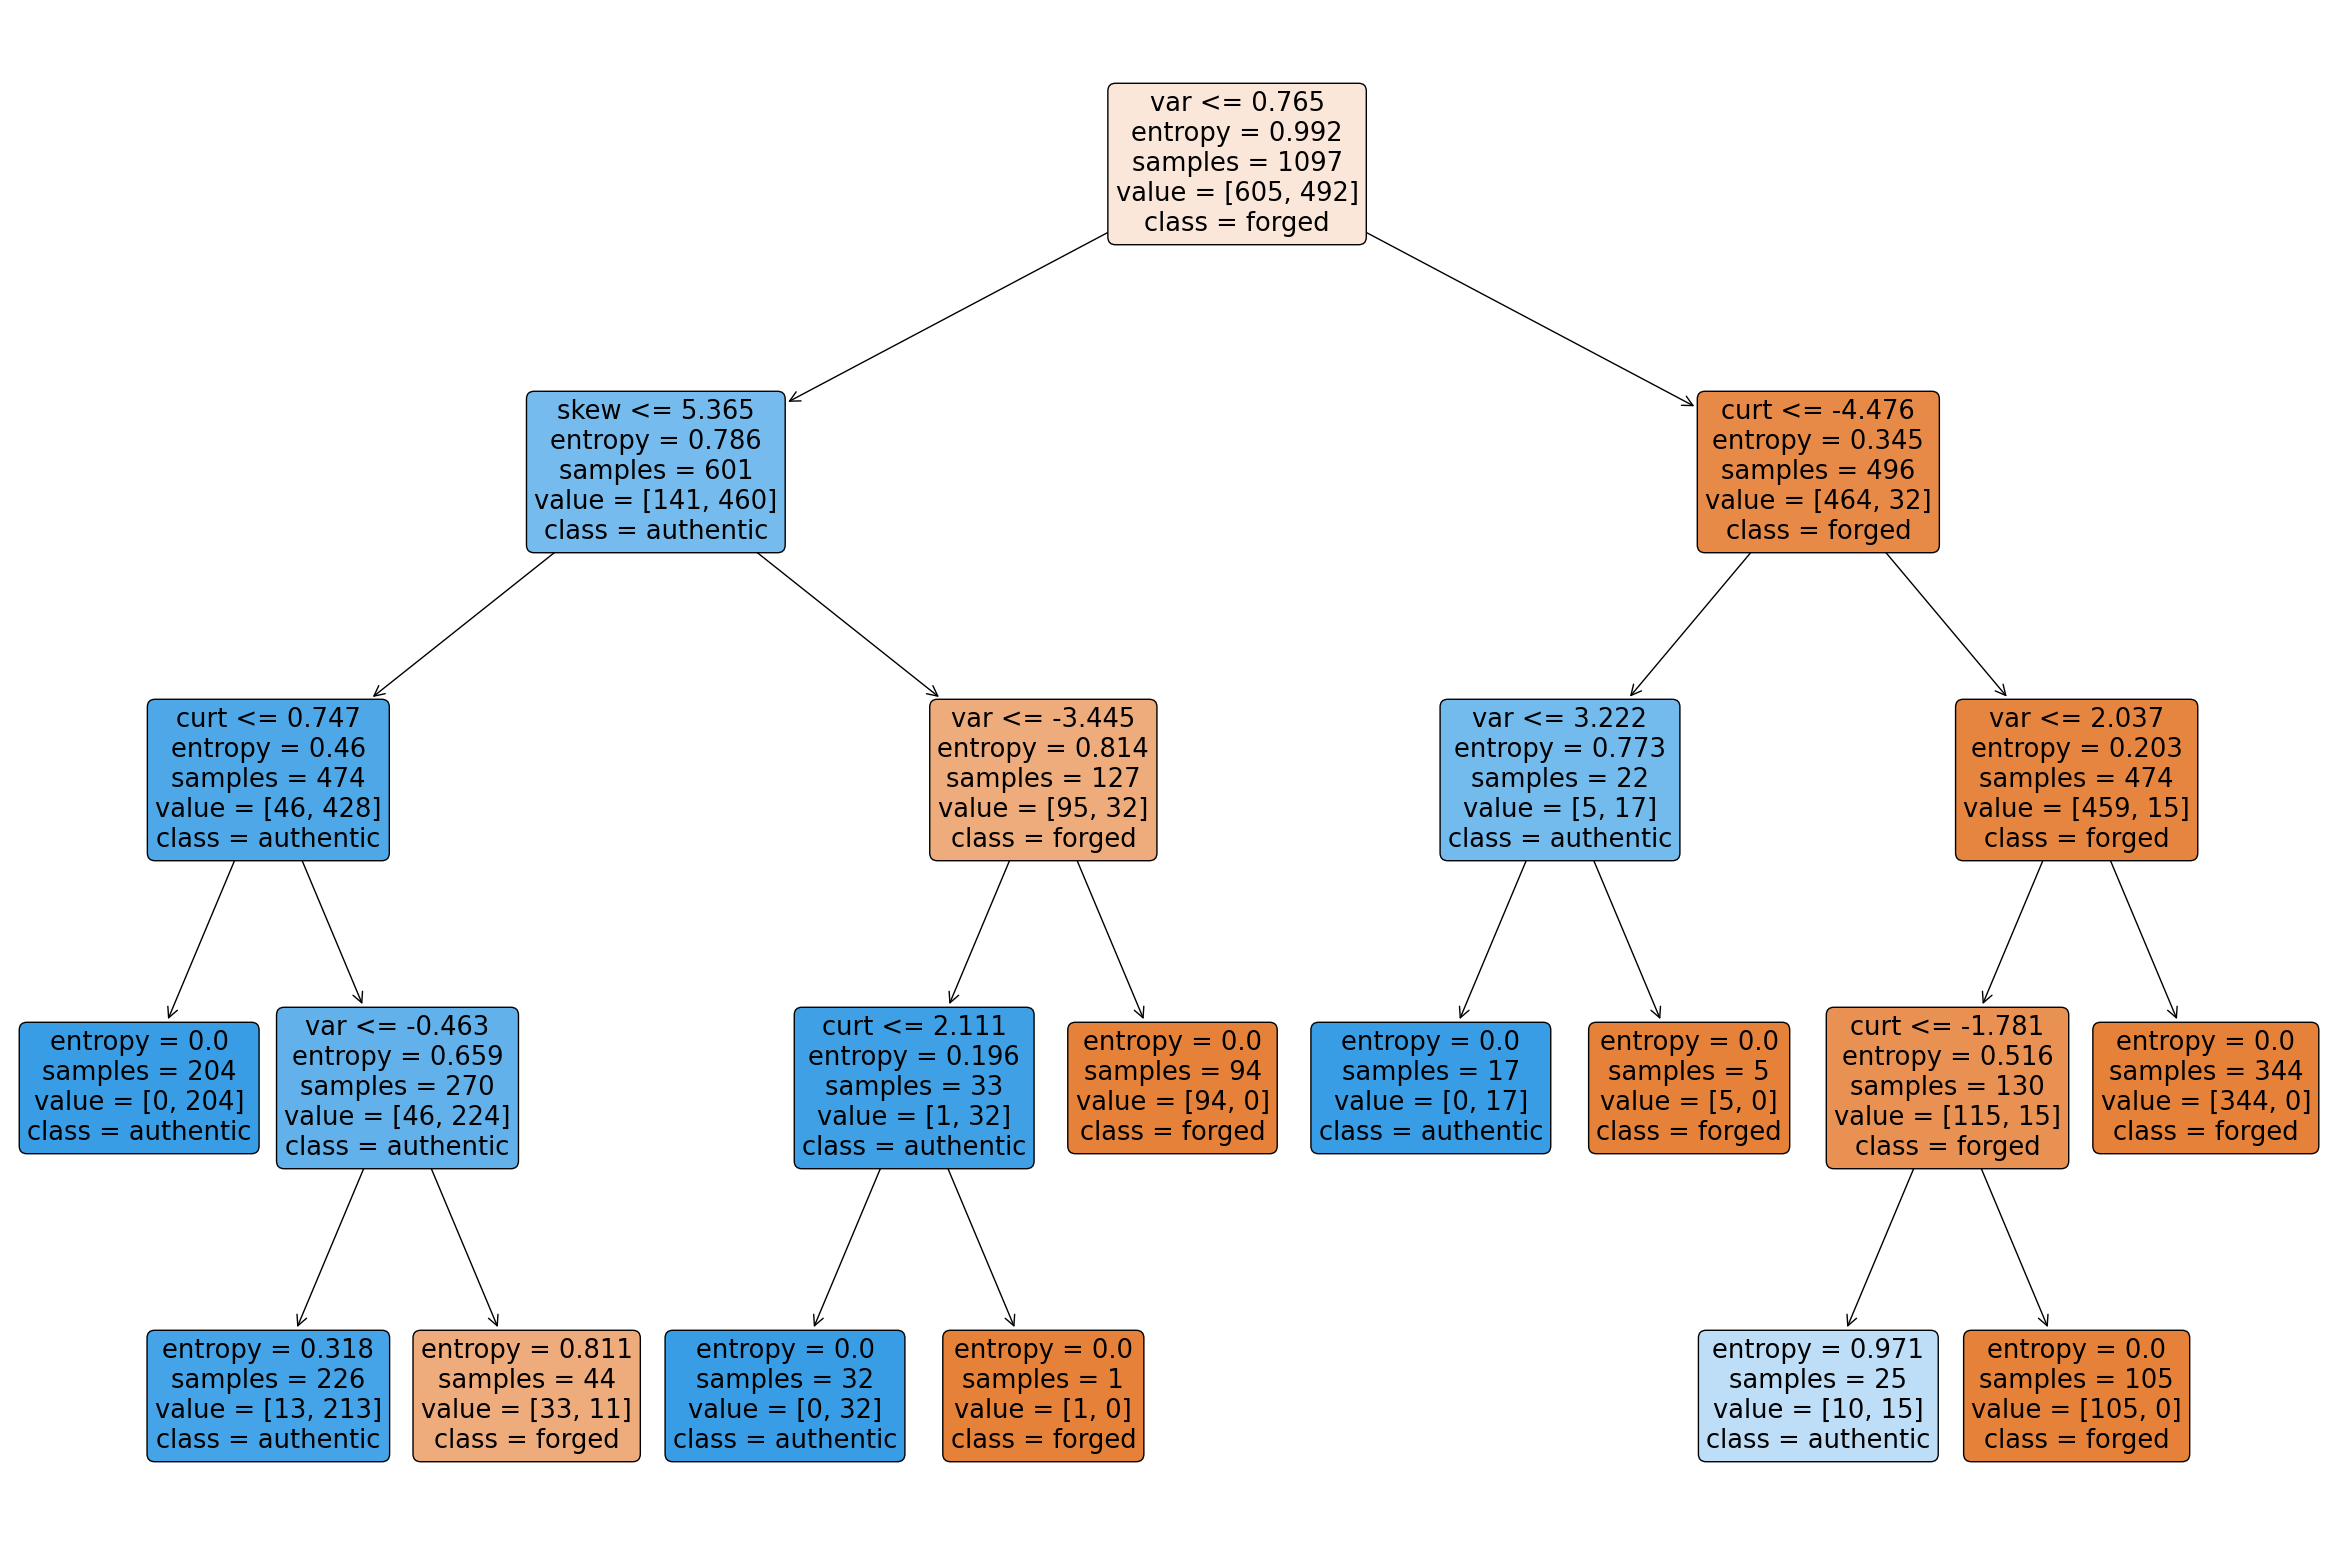

Accuracy value: 0.9527272727272728


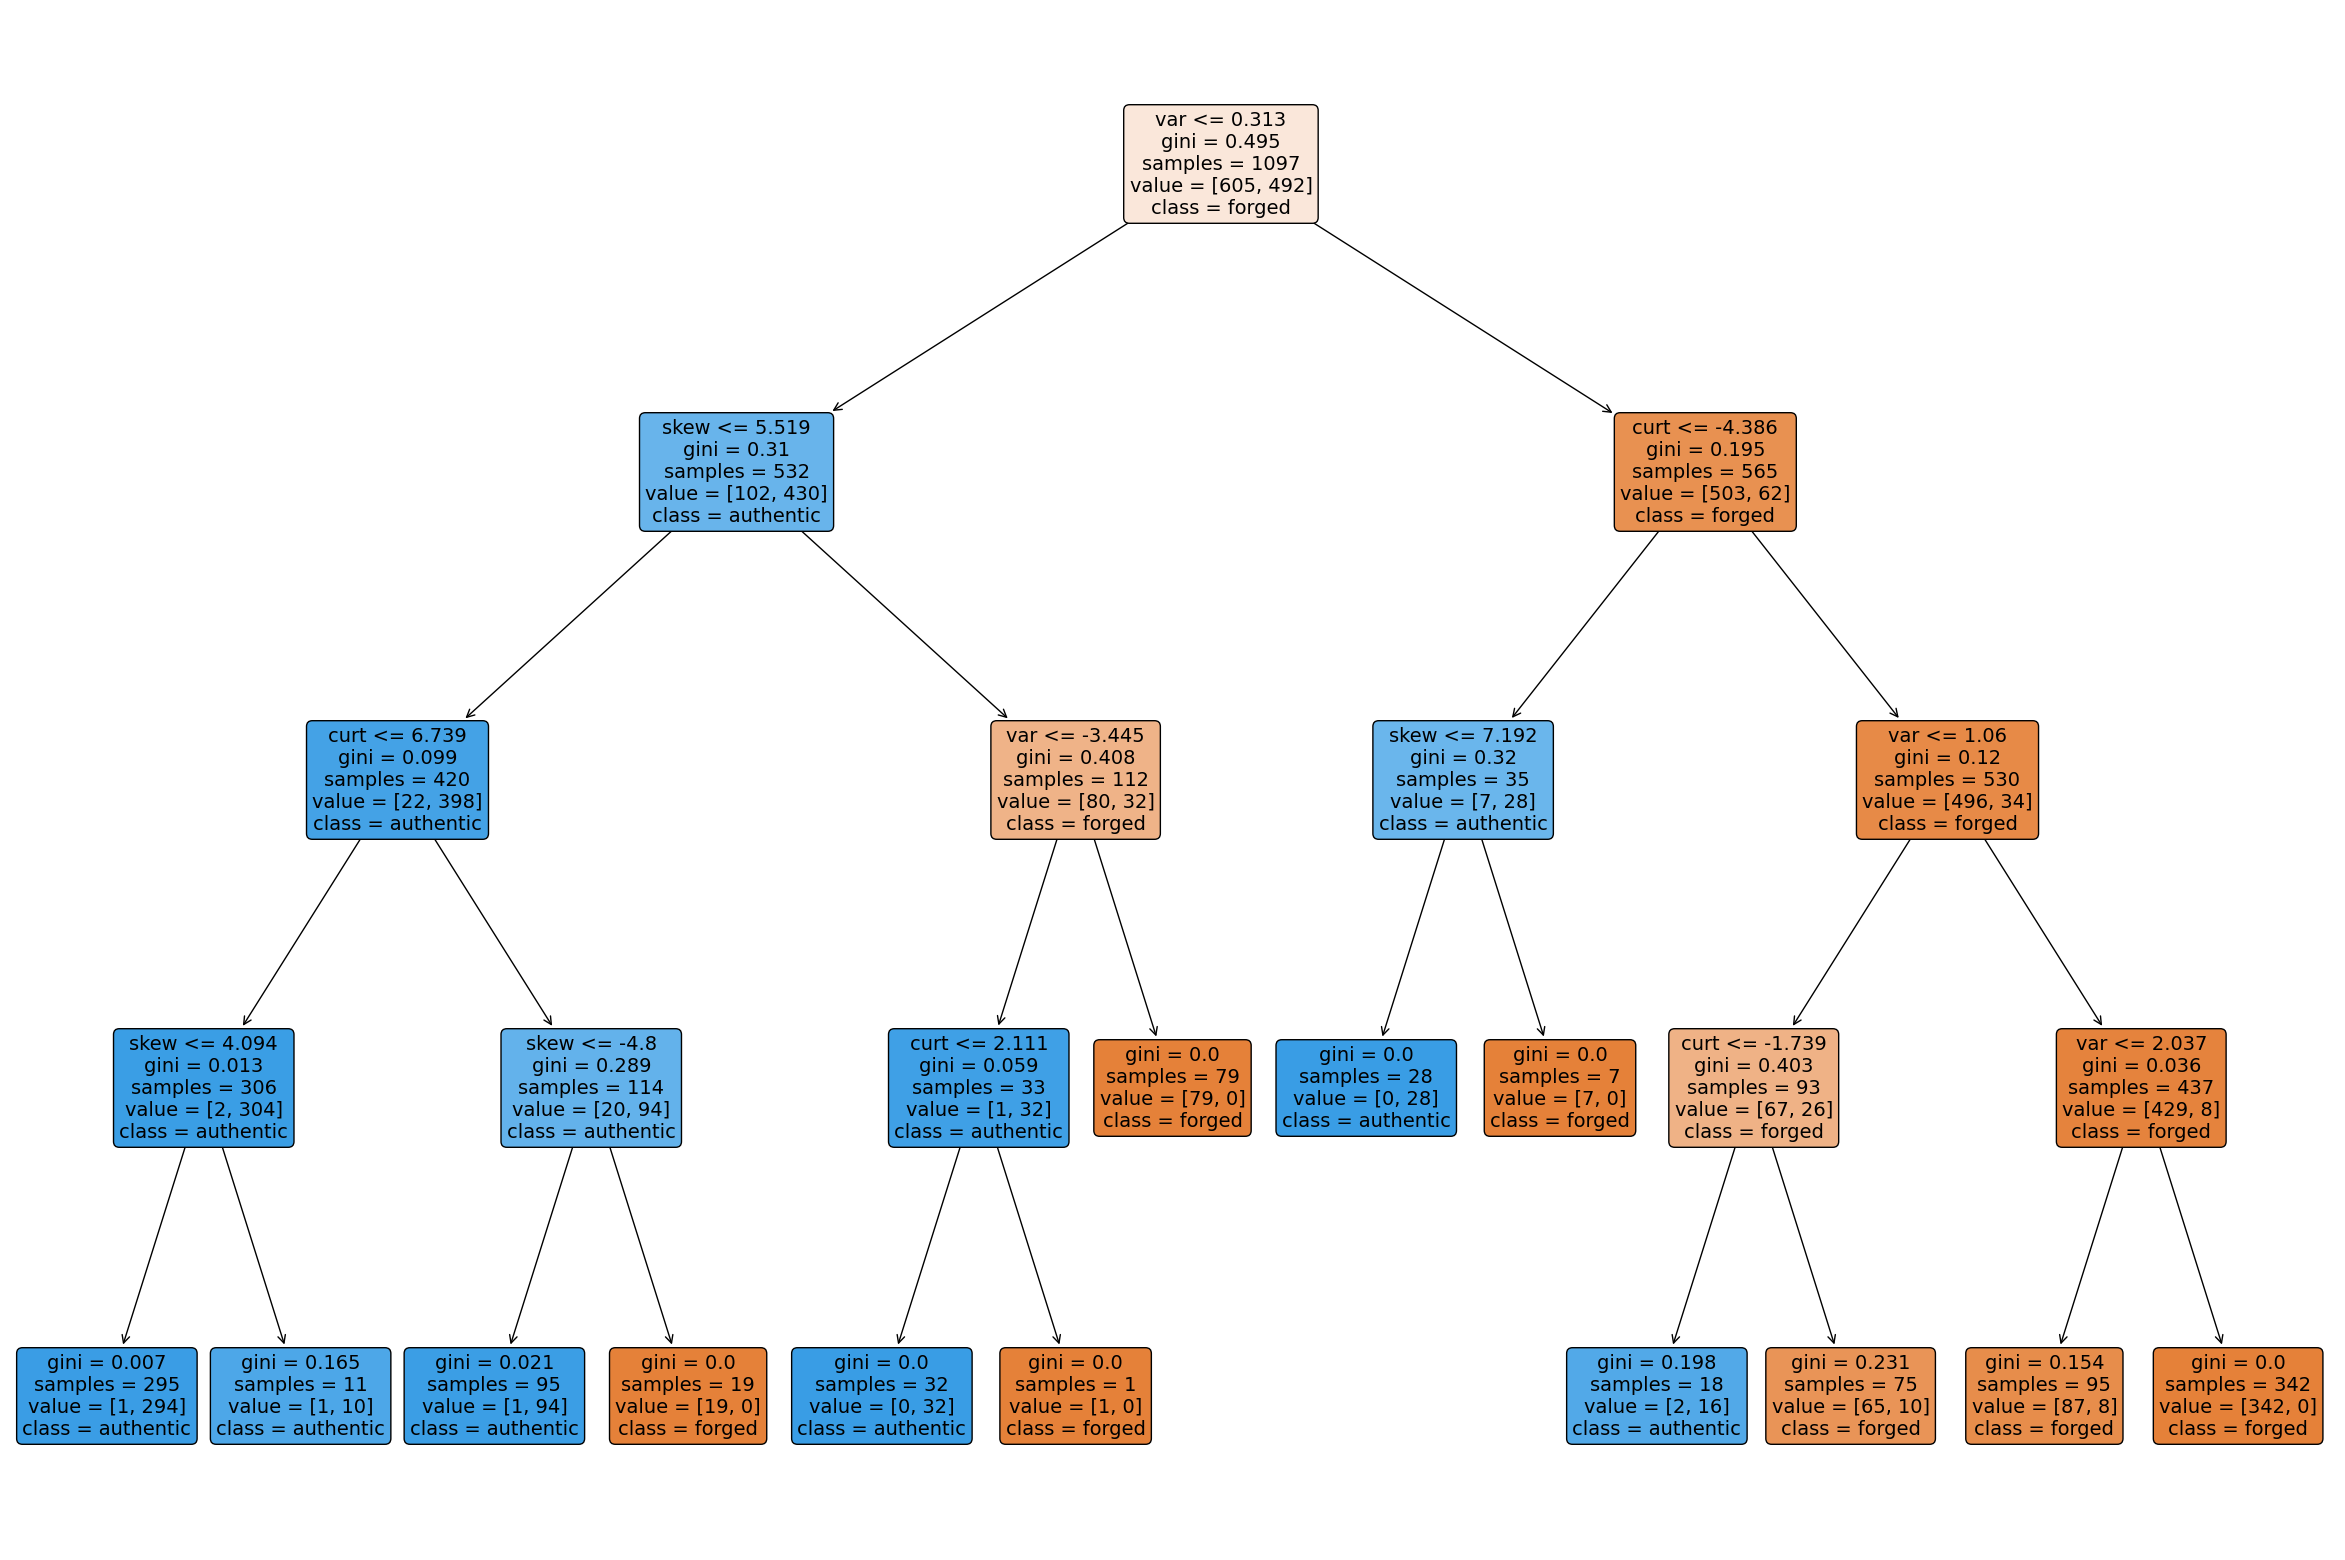

In [431]:
from sklearn.tree import DecisionTreeClassifier
for i in ["entropy","gini"]:
    clf = DecisionTreeClassifier(criterion=i,max_depth=4,min_samples_split=2)
    clf.fit(X_train,Y_train)
    Y_pred = clf.predict(X_test)
    print("Accuracy value:",accuracy_score(Y_test, Y_pred))
    plotTree(clf)
    

#### Varying min sample split values

Accuracy value: 0.96


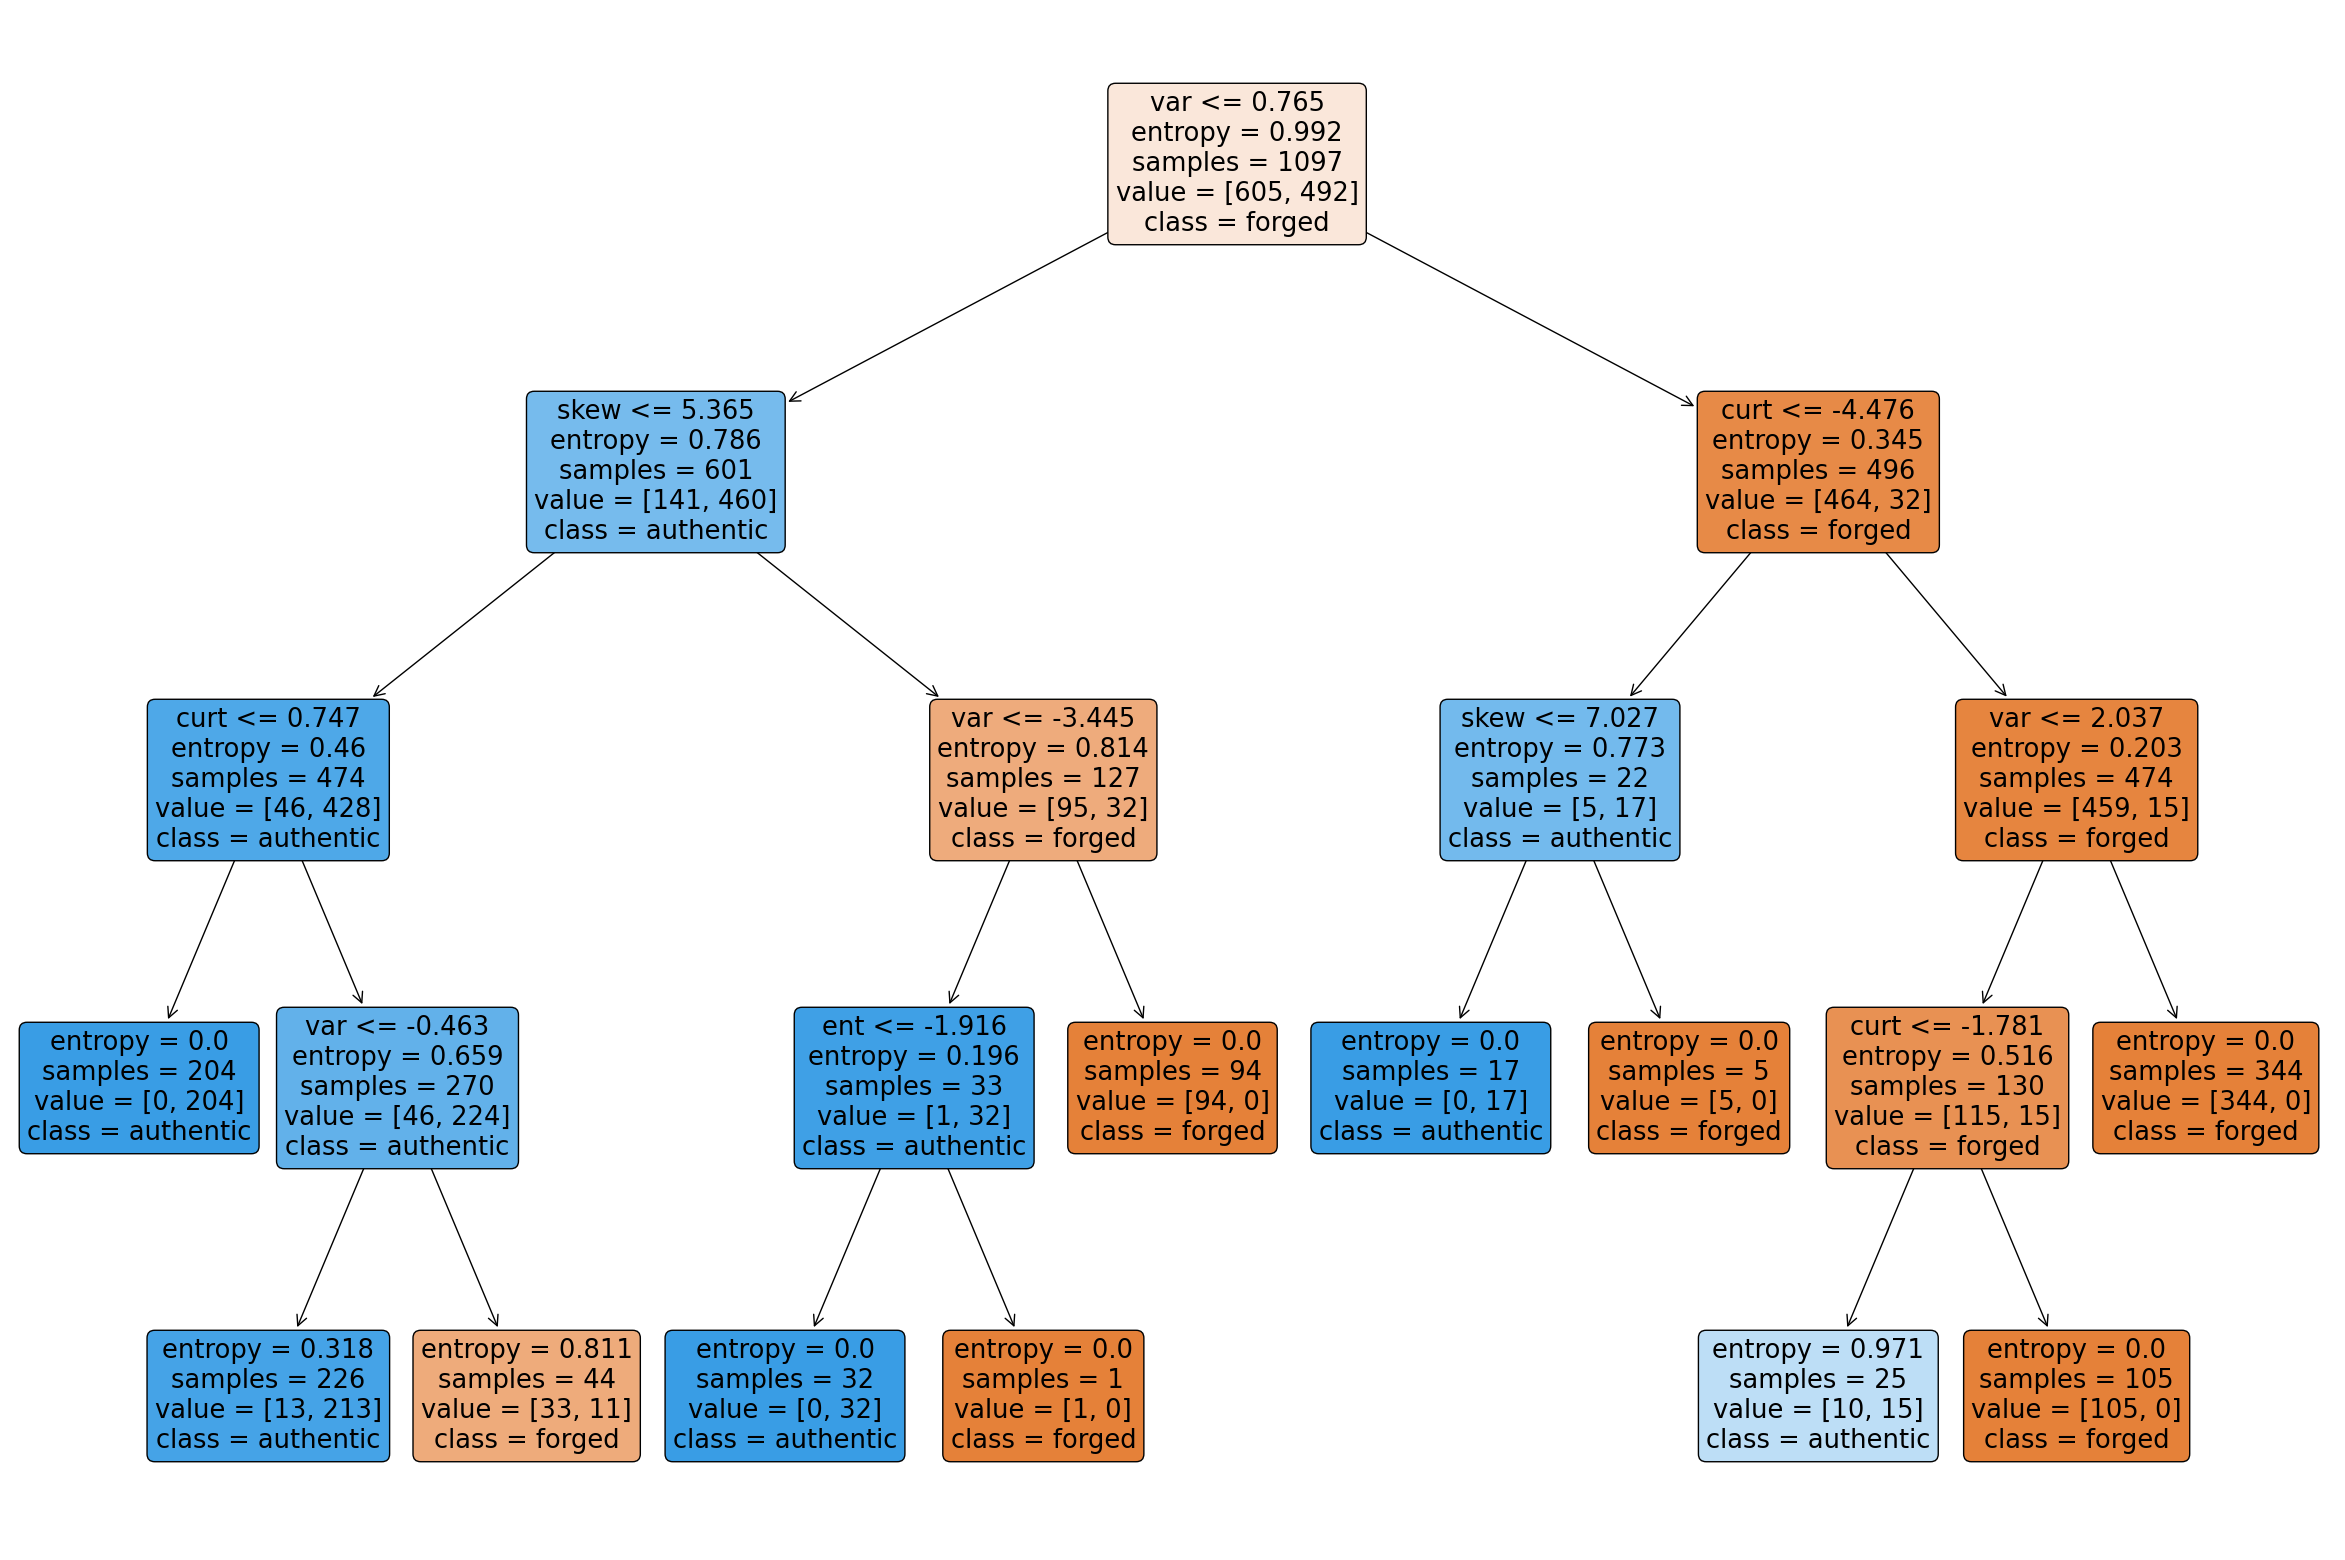

Accuracy value: 0.9490909090909091


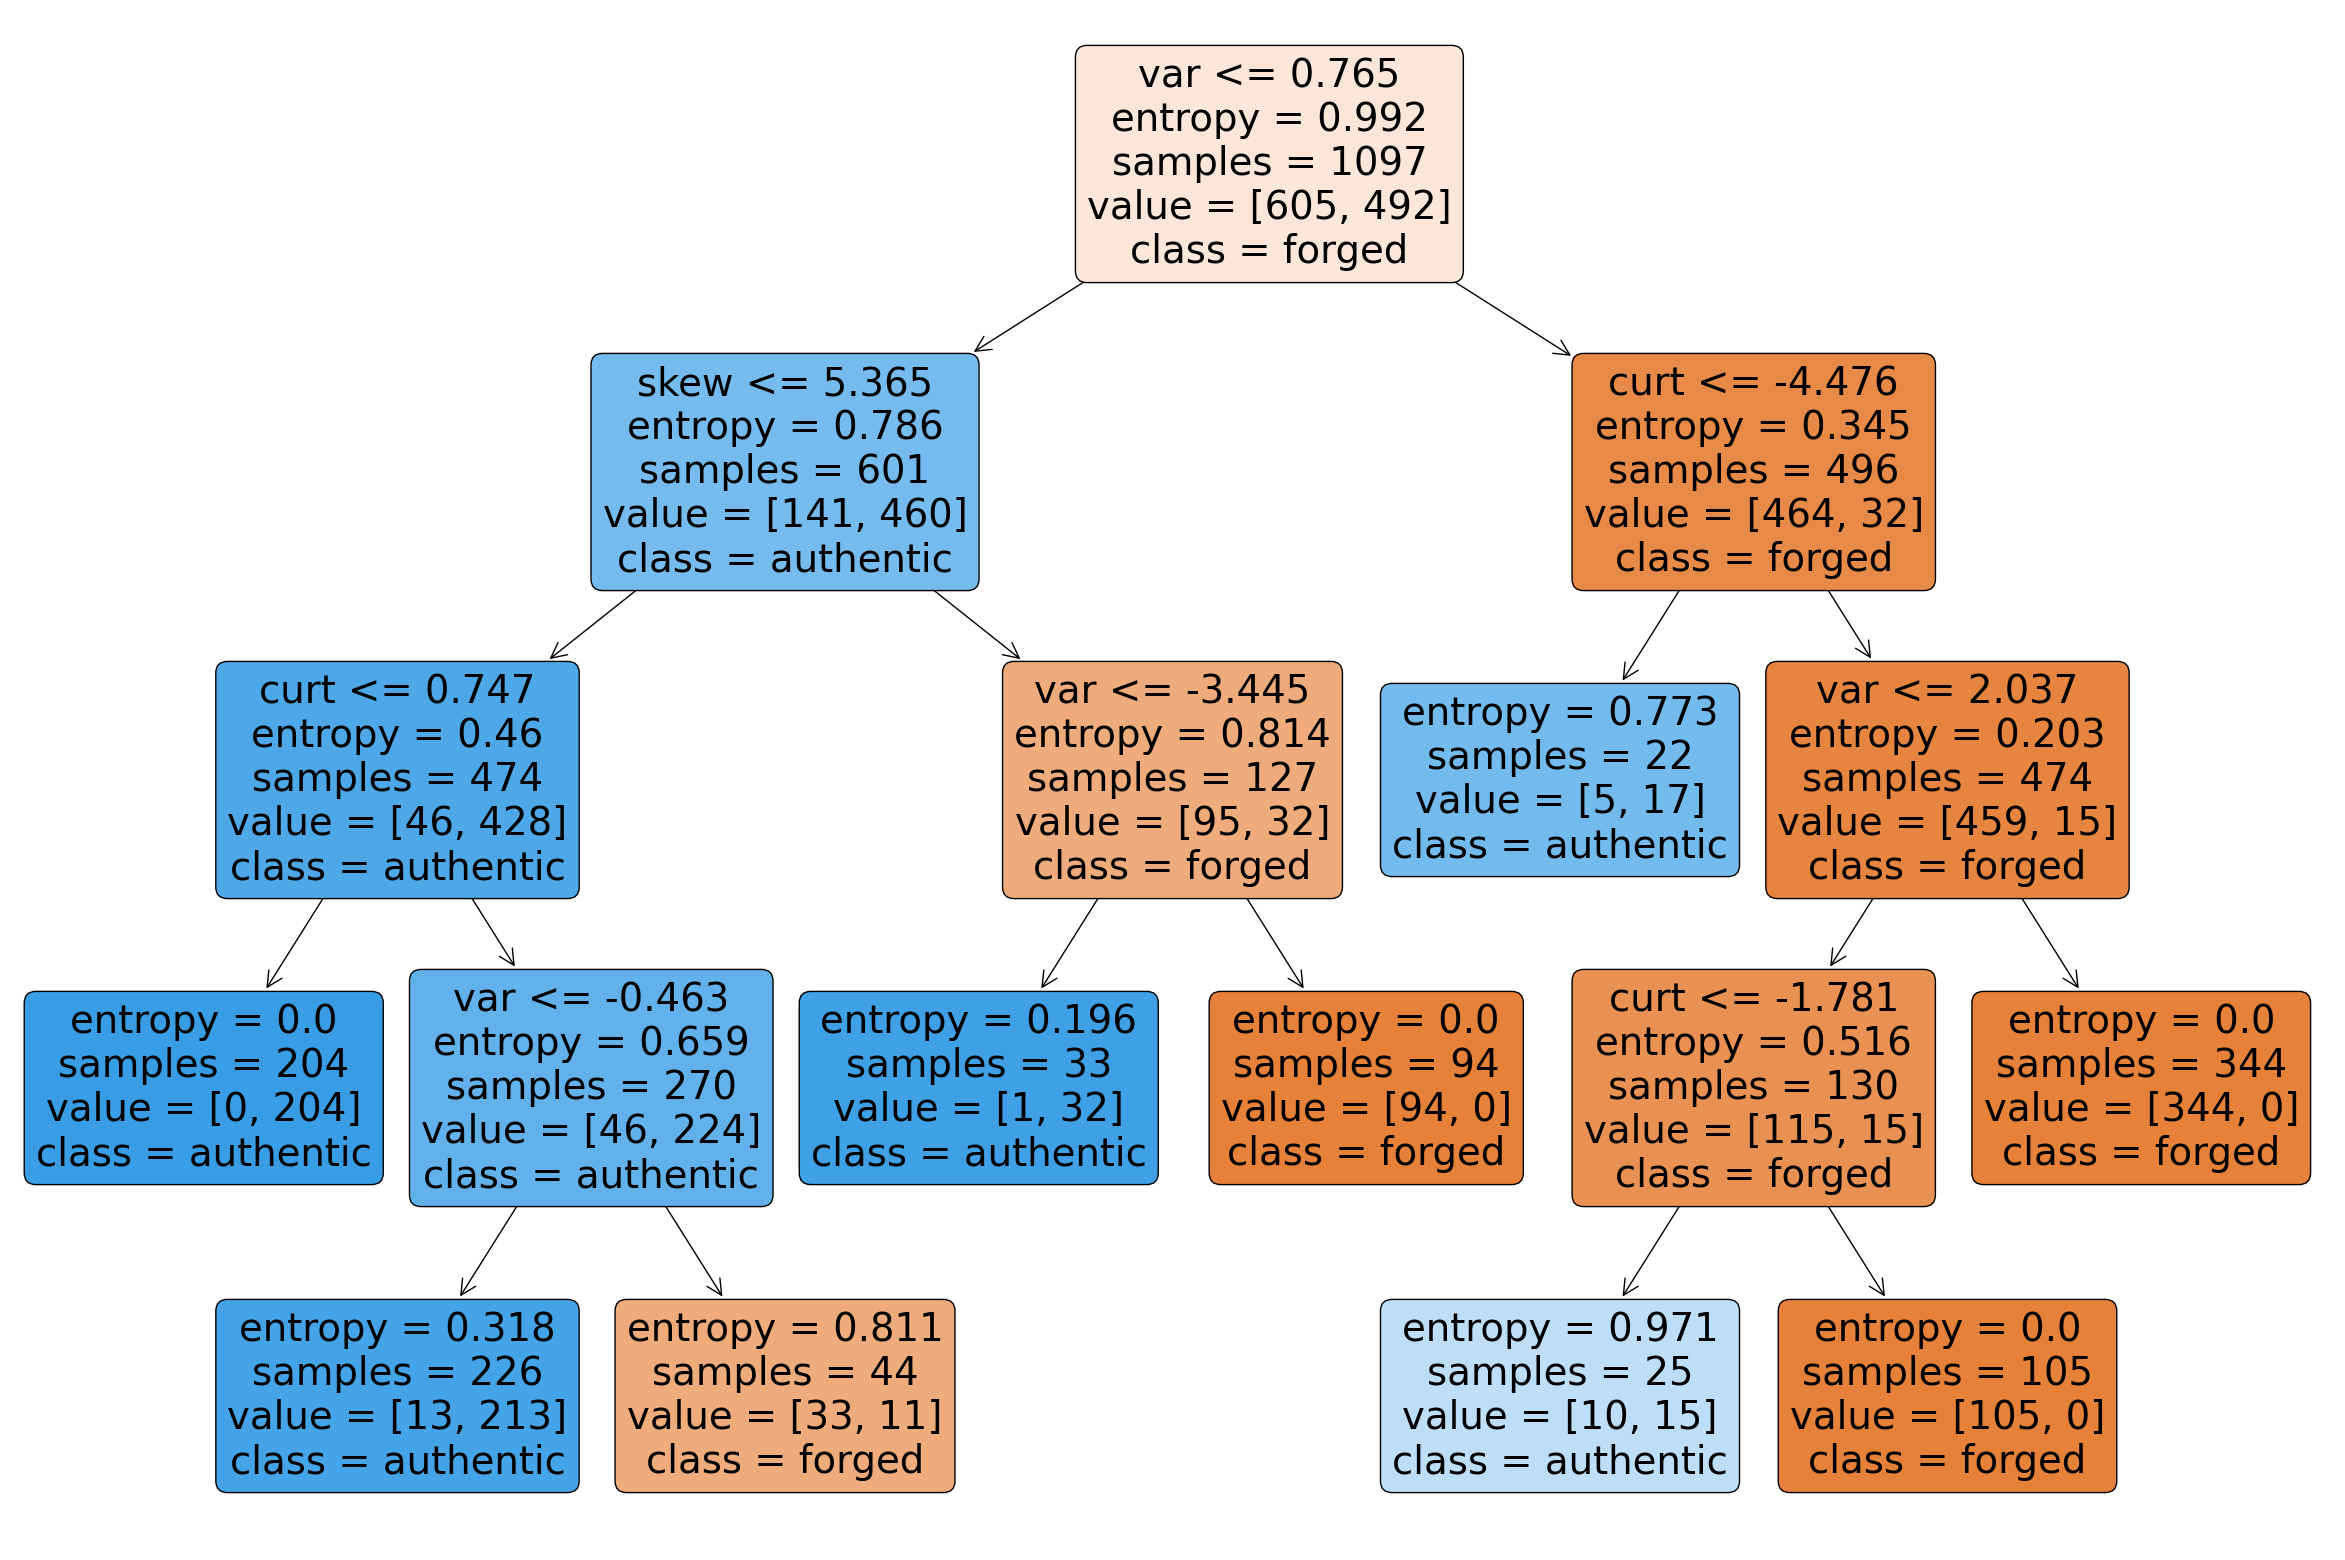

Accuracy value: 0.9490909090909091


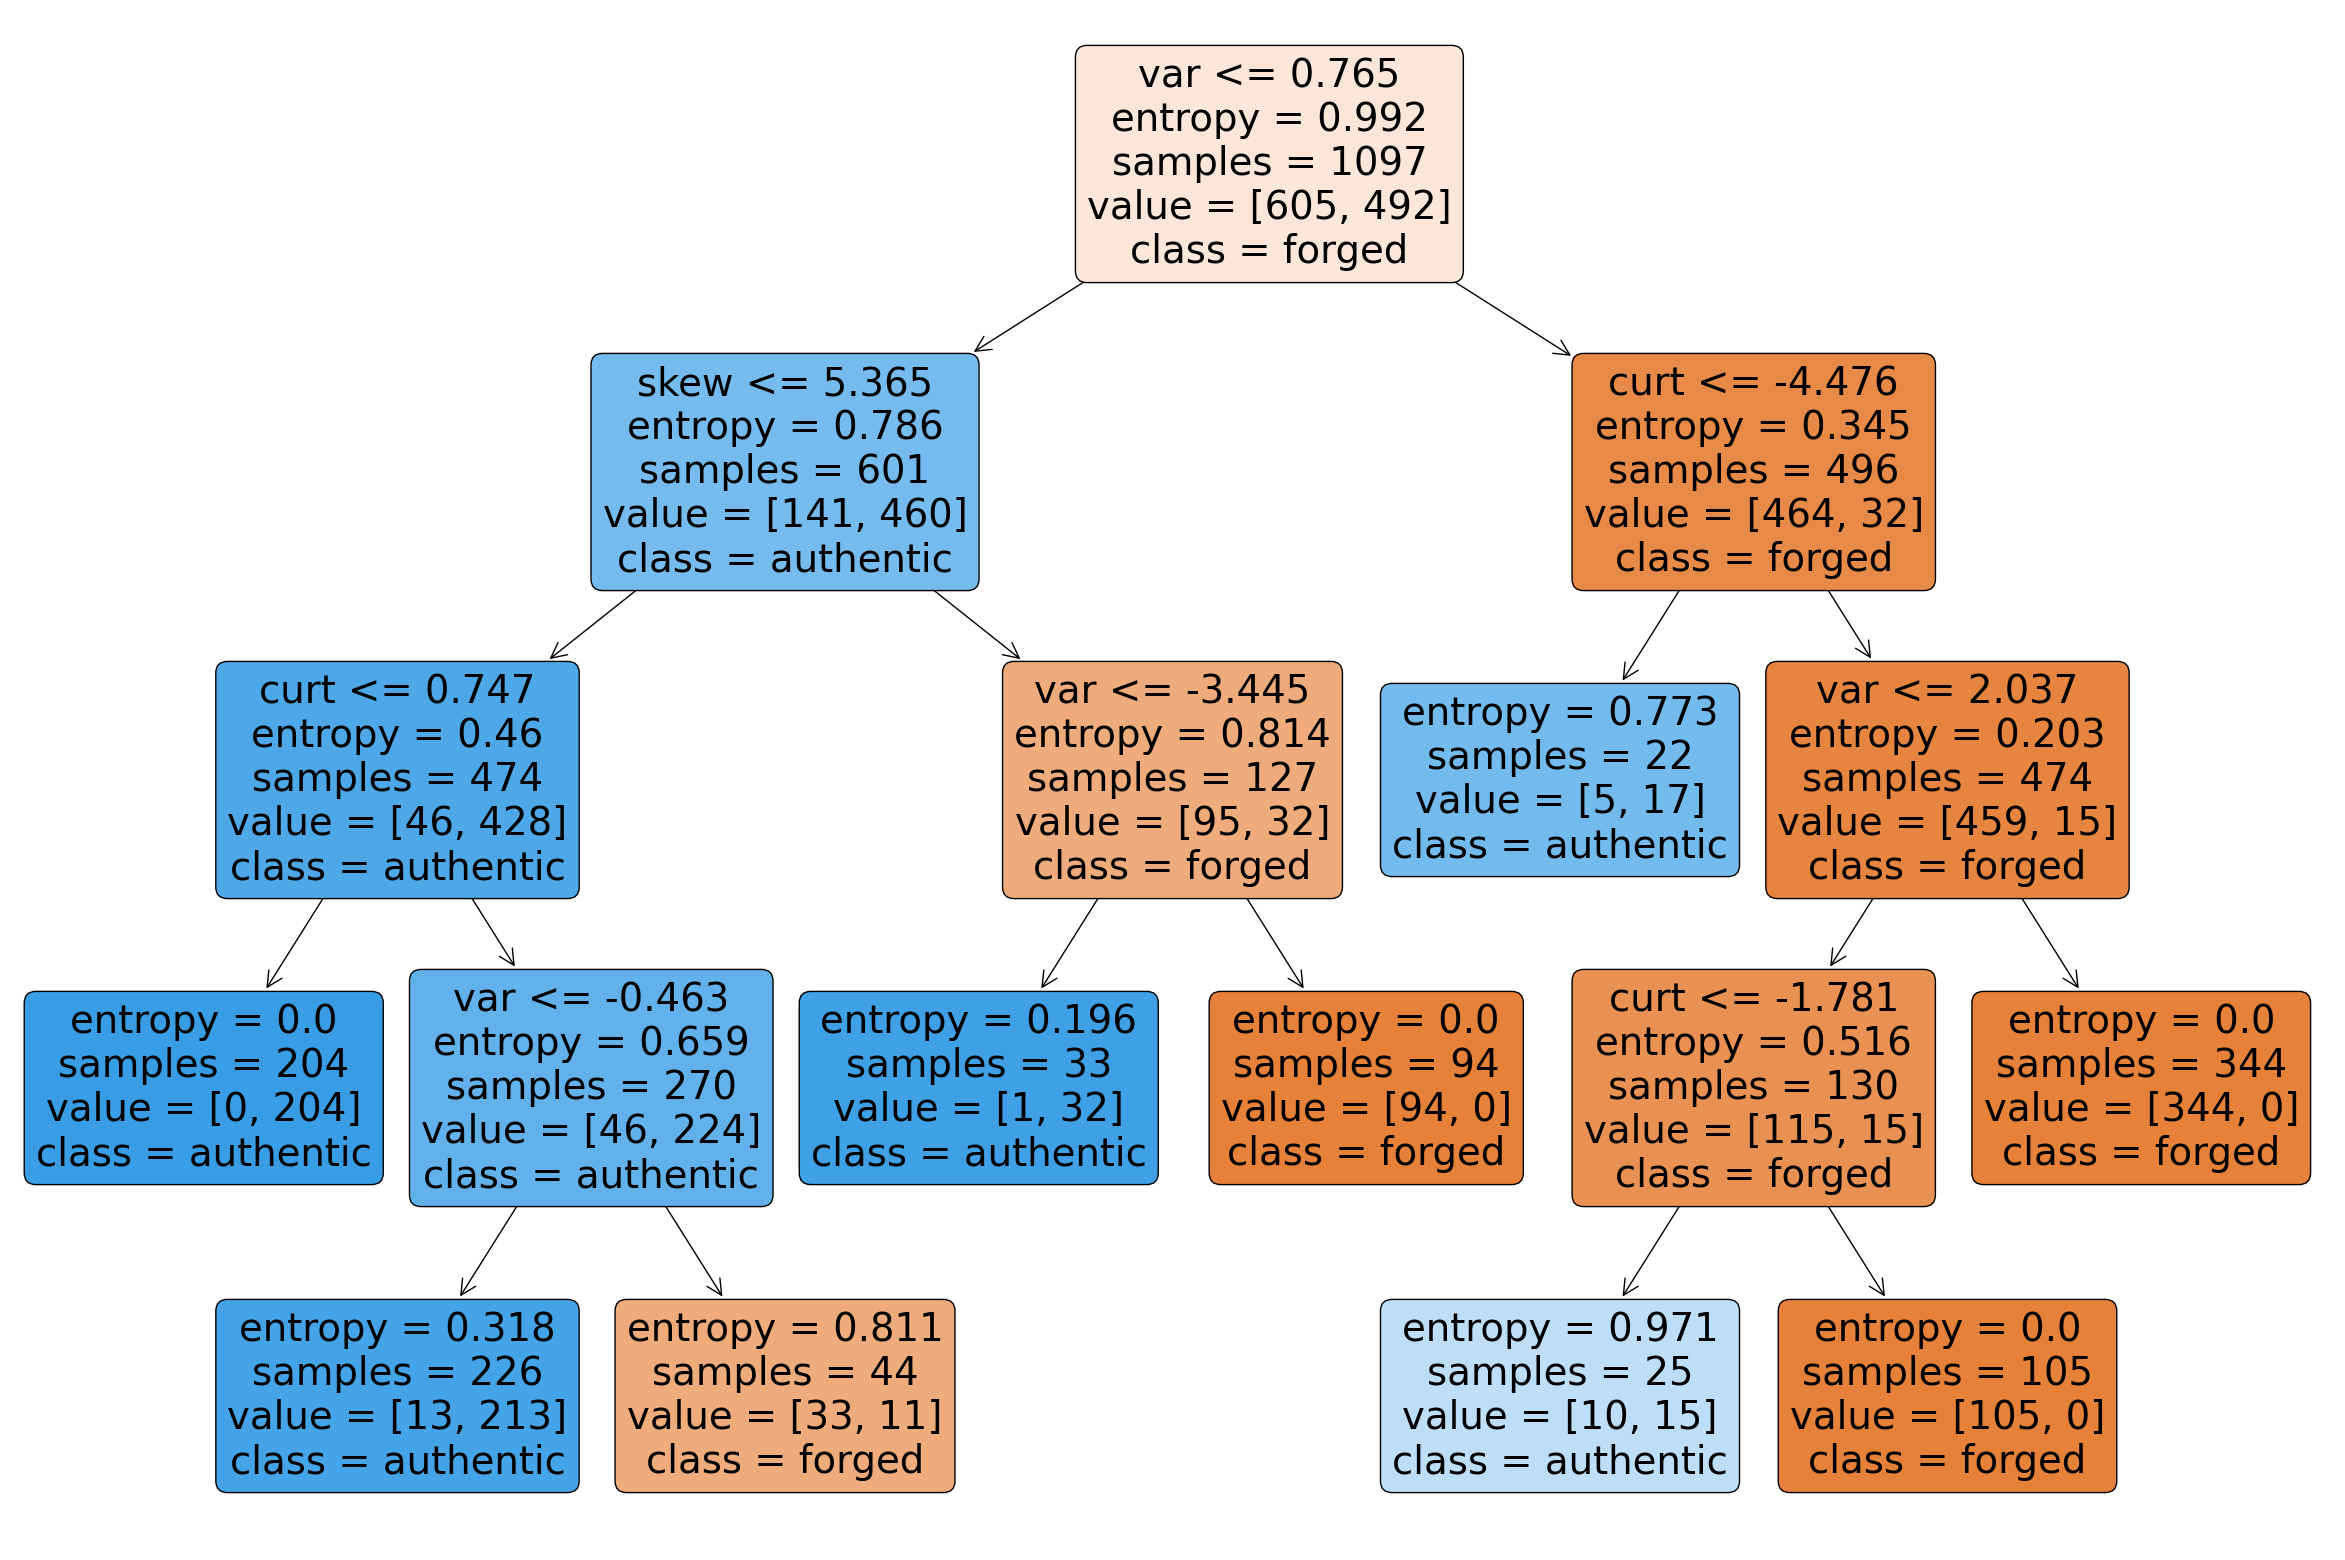

Accuracy value: 0.8836363636363637


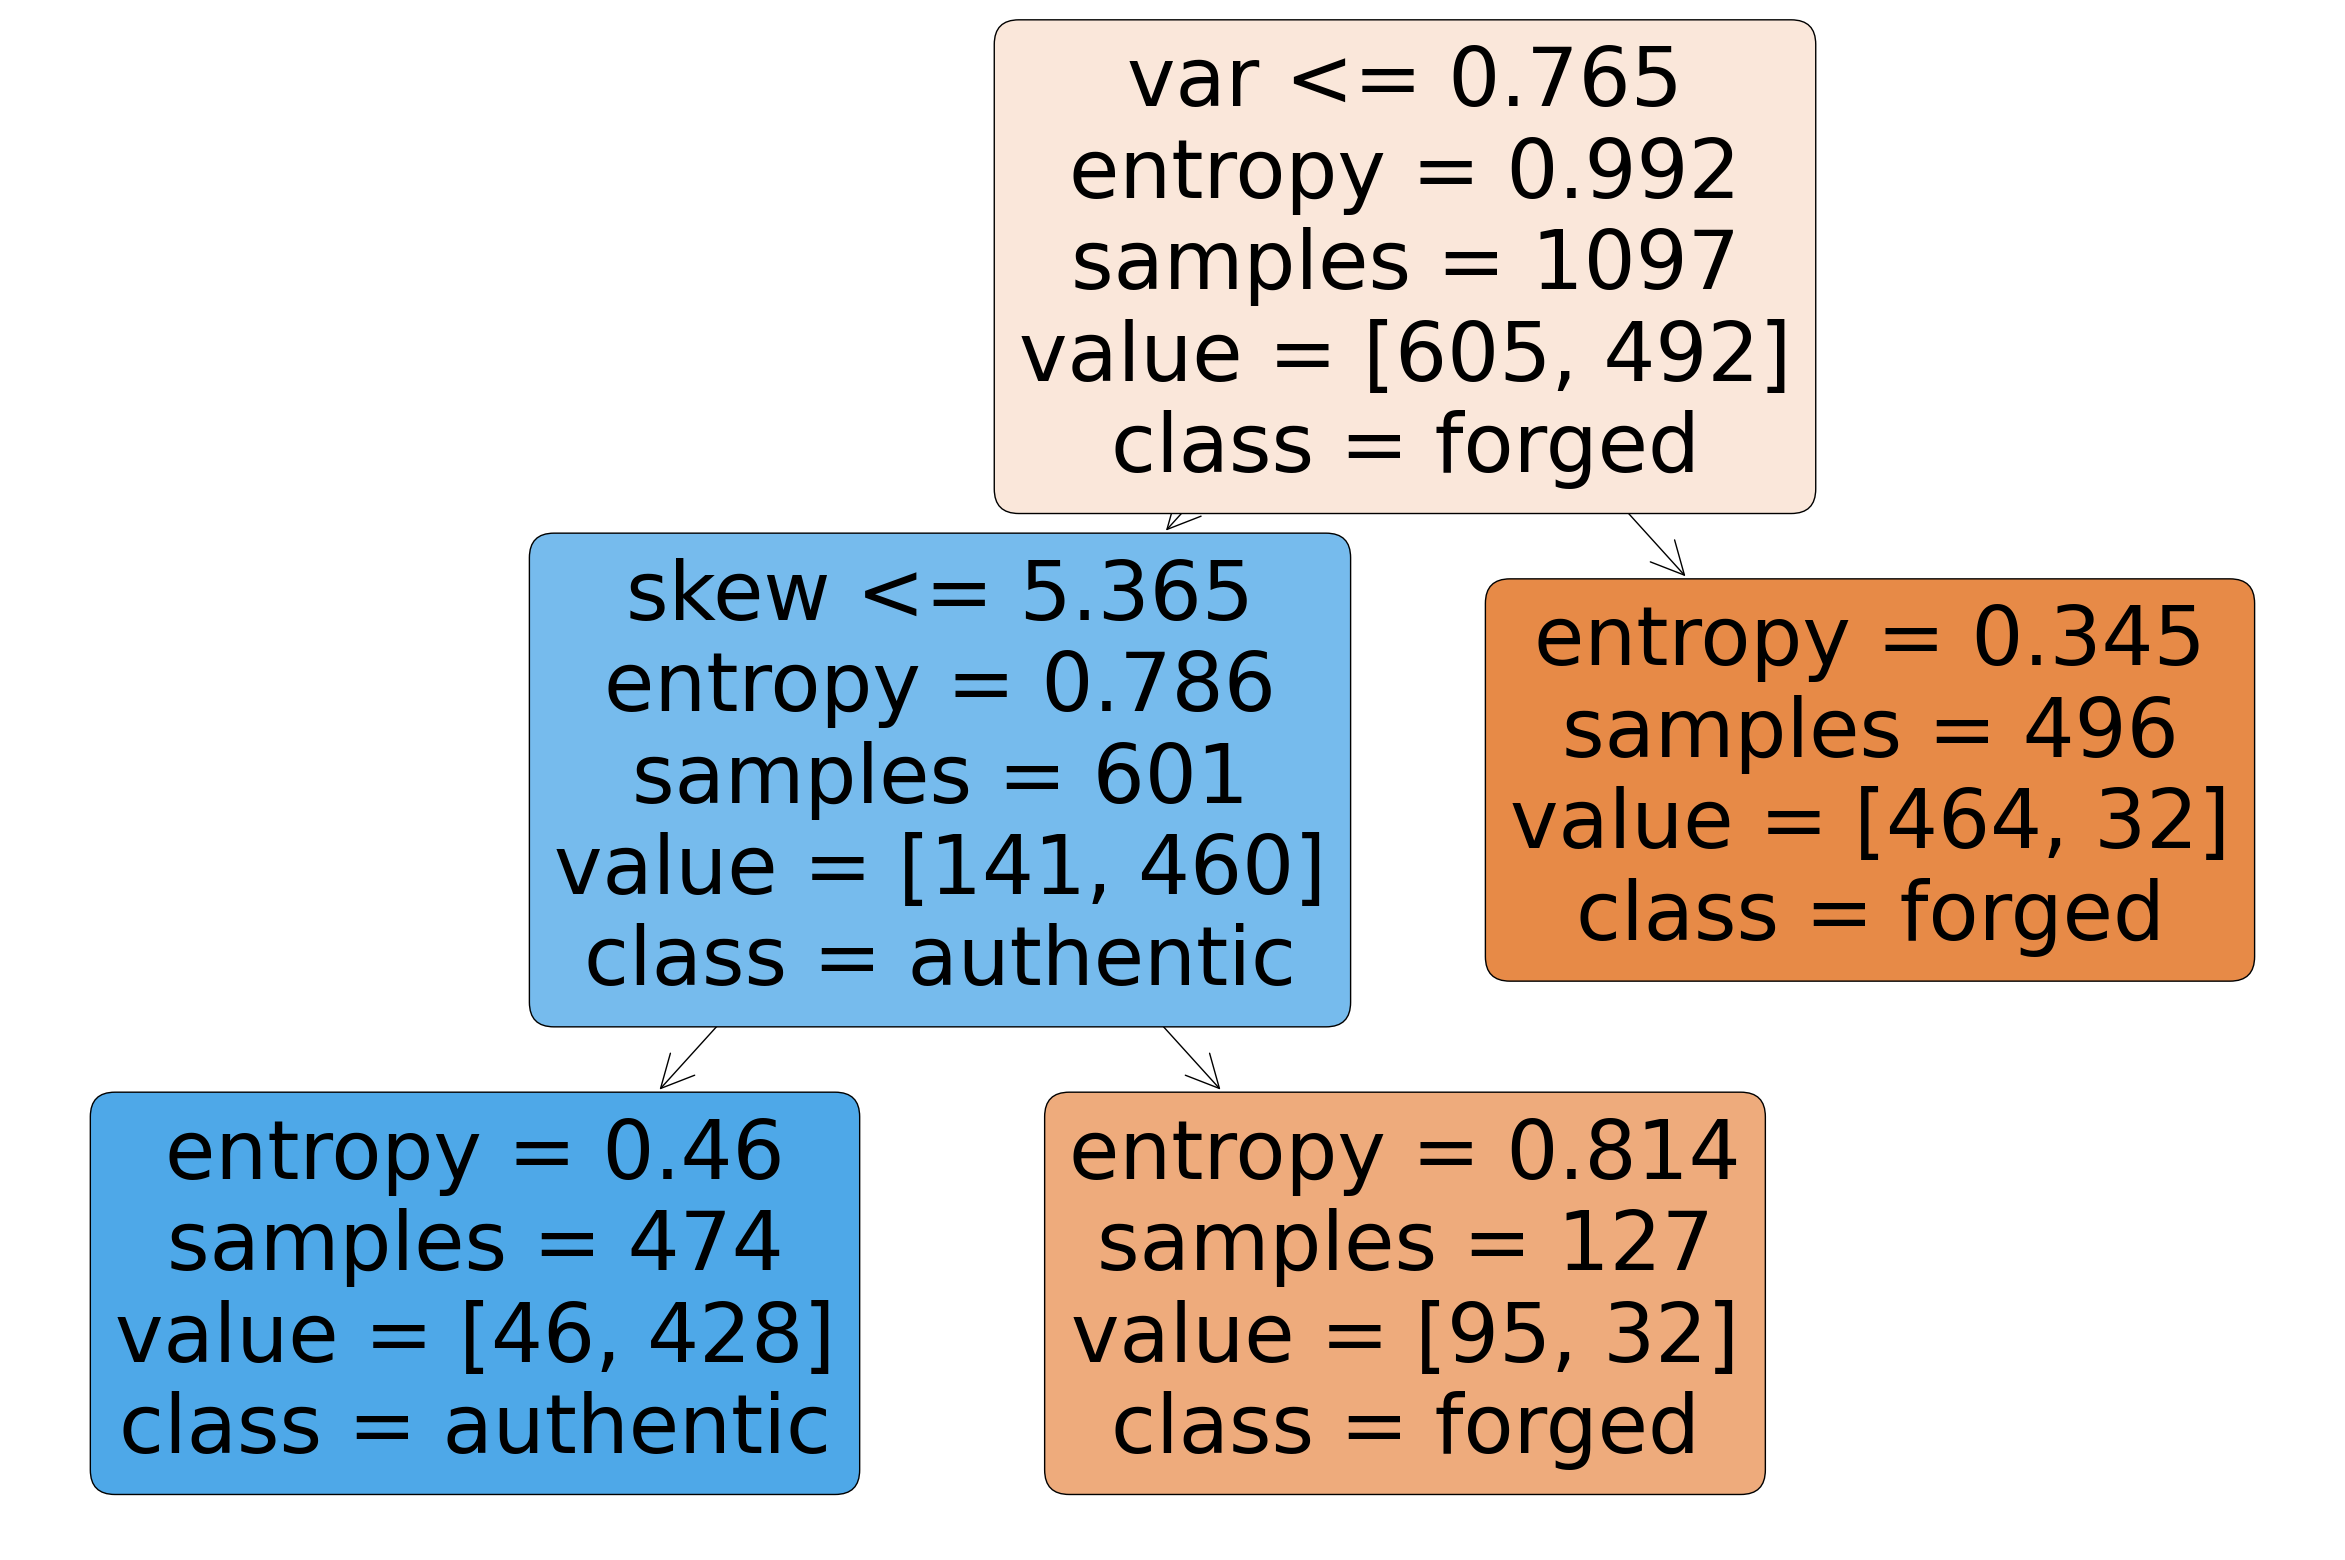

Accuracy value: 0.8290909090909091


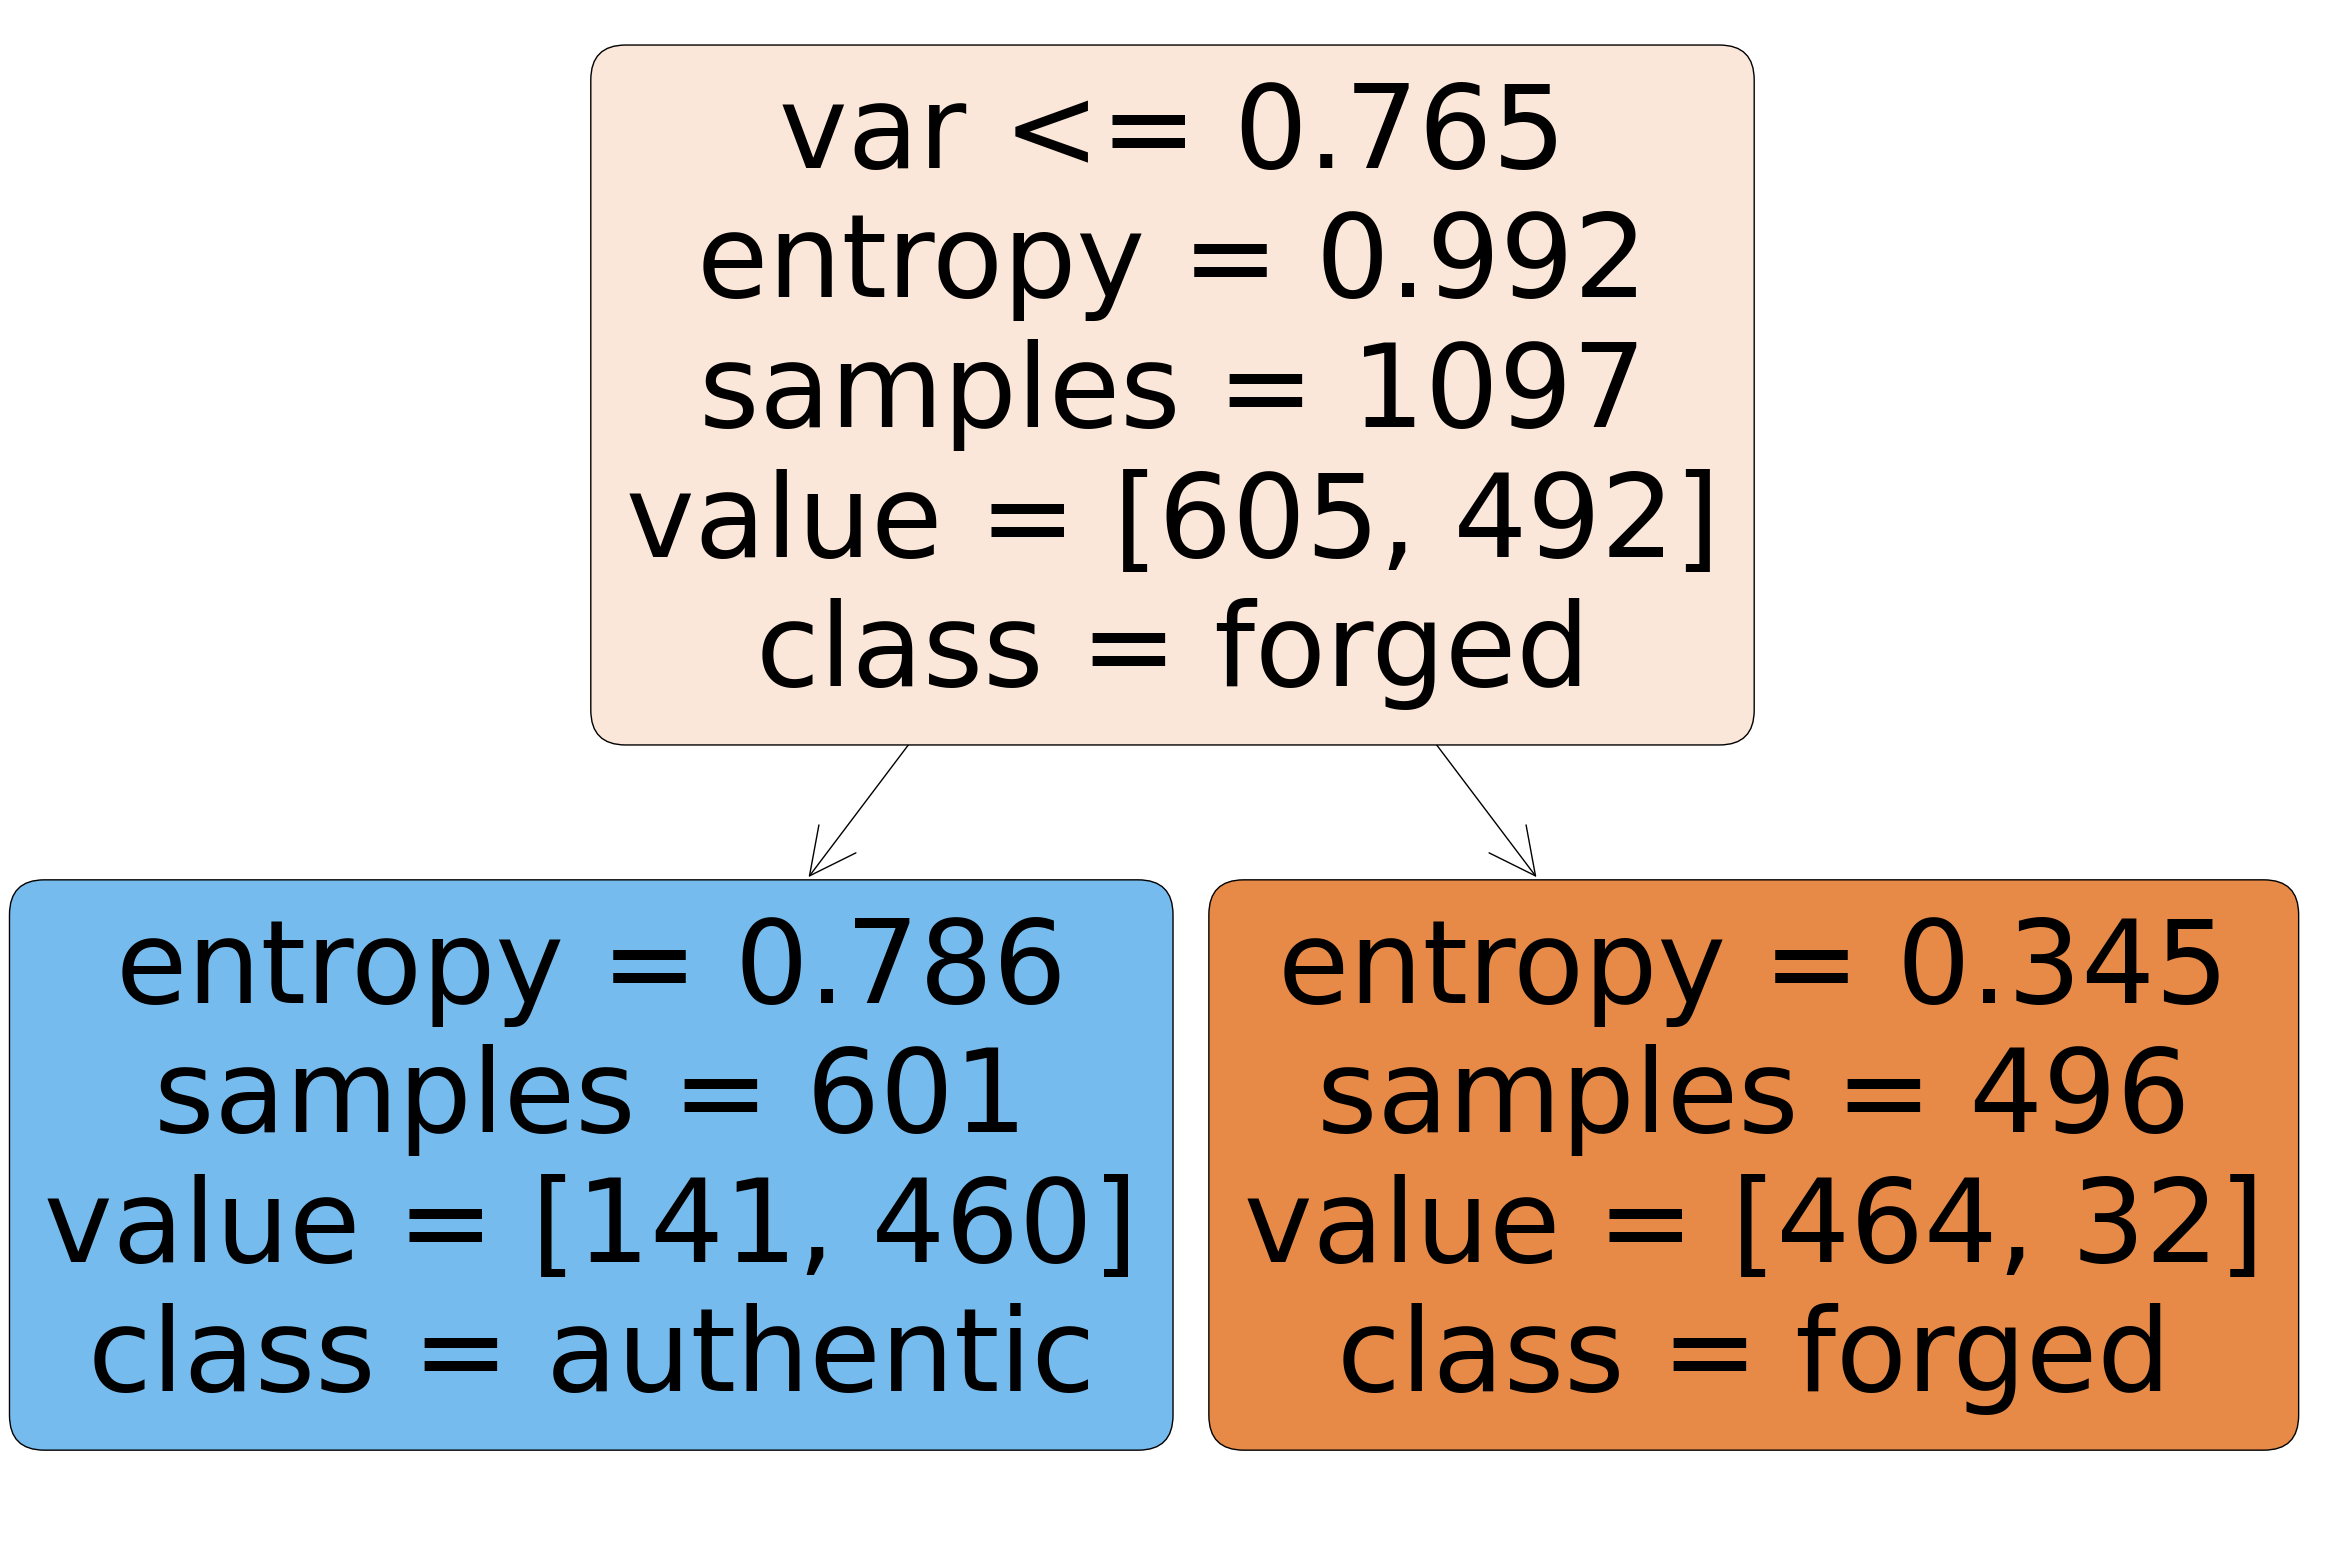

In [432]:
from sklearn.tree import DecisionTreeClassifier
for i in [10,50,100,500,1000]:
    clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_split=i)
    clf.fit(X_train,Y_train)
    Y_pred = clf.predict(X_test)
    print("Accuracy value:",accuracy_score(Y_test, Y_pred))
    plotTree(clf)
    

3. Graphs plotted above

2. As seen from the above graphs and observations, we get:
    - Increasing depth increases accuracy
    - Impurity criterion like entropy give differing results than gini w.r.t accuracy scores. The depth affects the performance of one over the other as well.
    - Decreasing number of minimum samples per split results in better accuracies, while increasing the same will result in trees having lower overall depth